## OpenLane Colab

This Google Colab notebook will:
* Install OpenLane and its dependencies
* Run a simple design, namely a serial-parallel multiplier, through the flow
  and targeting the [open source sky130 PDK](https://github.com/google/skywater-pdk/)
  by Google and Skywater.

In [ ]:
# @title Setup Nix {display-mode: "form"}
# @markdown <img src="https://raw.githubusercontent.com/NixOS/nixos-artwork/master/logo/nix-snowflake.svg" width="32"/>
# @markdown
# @markdown Nix is a package manager with an emphasis on reproducible builds,
# @markdown and it is the primary method for installing OpenLane 2.
# @markdown
# @markdown This step installs the Nix package manager and enables the
# @markdown experimental "flakes" feature.
# @markdown
# @markdown If you're not in a Colab, this just sets the environment variables.
# @markdown You will need to install Nix and enable flakes on your own following
# @markdown [this guide](https://openlane2.readthedocs.io/en/stable/getting_started/common/nix_installation/index.html).
import os
import sys
import shutil

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

In [ ]:
# @title Get OpenLane {display-mode: "form"}
# @markdown Click the ▷ button to download and install OpenLane.
# @markdown
# @markdown This will install OpenLane's tool dependencies using Nix,
# @markdown and OpenLane itself using PIP.
# @markdown
# @markdown Note that `python3-tk` may need to be installed using your OS's
# @markdown package manager.
import os
import subprocess
import IPython

openlane_version = "version-2.1"  # @param {key:"OpenLane Version", type:"string"}

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"  # @param {key:"PDK Root", type:"string"}

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"  # @param {key:"PDK (without the variant)", type:"string"}

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

In [37]:
import openlane

print(openlane.__version__)

2.1.11


### Creating the design

Now that OpenLane is set up, we can write a Verilog file as follows:

In [39]:
%%writefile spm.v
module spm(clk, rst, x, y, p);
    parameter size = 32;
    input clk, rst;
    input y;
    input[size-1:0] x;
    output p;

    wire[size-1:1] pp;
    wire[size-1:0] xy;

    genvar i;

    CSADD csa0 (.clk(clk), .rst(rst), .x(x[0]&y), .y(pp[1]), .sum(p));
    generate for(i=1; i<size-1; i=i+1) begin
        CSADD csa (.clk(clk), .rst(rst), .x(x[i]&y), .y(pp[i+1]), .sum(pp[i]));
    end endgenerate
    TCMP tcmp (.clk(clk), .rst(rst), .a(x[size-1]&y), .s(pp[size-1]));

endmodule

module TCMP(clk, rst, a, s);
    input clk, rst;
    input a;
    output reg s;

    reg z;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            s <= 1'b0;
            z <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            z <= a | z;
            s <= a ^ z;
        end
    end
endmodule

module CSADD(clk, rst, x, y, sum);
    input clk, rst;
    input x, y;
    output reg sum;

    reg sc;

    // Half Adders logic
    wire hsum1, hco1;
    assign hsum1 = y ^ sc;
    assign hco1 = y & sc;

    wire hsum2, hco2;
    assign hsum2 = x ^ hsum1;
    assign hco2 = x & hsum1;

    always @(posedge clk or posedge rst) begin
        if (rst) begin
            //Reset logic goes here.
            sum <= 1'b0;
            sc <= 1'b0;
        end
        else begin
            //Sequential logic goes here.
            sum <= hsum2;
            sc <= hco1 ^ hco2;
        end
    end
endmodule

Overwriting spm.v


### Setting up the configuration

OpenLane requries you to configure any Flow before using it. This is done using
the `config` module.

For colaboratories, REPLs and other interactive environments where there is no
concrete Flow object, the Configuration may be initialized using `Config.interactive`,
which will automatically propagate the configuration to any future steps.

You can find the documentation for `Config.interactive` [here](https://openlane2.readthedocs.io/en/latest/reference/api/config/index.html#openlane.config.Config.interactive).



In [40]:
from openlane.config import Config

Config.interactive(
    "spm",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=10,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)


### Interactive Configuration
#### Initial Values

<br />

```yaml
CELL_BB_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd__blackbox_pp.v
CELL_GDS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/gds/sky130_fd_sc_hd.gds
CELL_LEFS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef
CELL_PAD_EXCLUDE:
- sky130_fd_sc_hd__tap*
- sky130_fd_sc_hd__decap*
- sky130_ef_sc_hd__decap*
- sky130_fd_sc_hd__fill*
CELL_SPICE_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice
CELL_VERILOG_MODELS:
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/primitives.v
- /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/verilog/sky130_fd_sc_hd.v
CLOCK_NET: clk
CLOCK_PERIOD: 10
CLOCK_PORT: clk
CLOCK_TRANSITION_CONSTRAINT: 0.15
CLOCK_UNCERTAINTY_CONSTRAINT: 0.25
CLOCK_WIRE_RC_LAYERS: null
DECAP_CELL:
- sky130_ef_sc_hd__decap_12
- sky130_fd_sc_hd__decap_8
- sky130_fd_sc_hd__decap_6
- sky130_fd_sc_hd__decap_4
- sky130_fd_sc_hd__decap_3
DEFAULT_CORNER: nom_tt_025C_1v80
DEFAULT_MAX_TRAN: null
DESIGN_DIR: .
DESIGN_NAME: spm
DIE_AREA: null
DIODE_CELL: sky130_fd_sc_hd__diode_2/DIODE
ENDCAP_CELL: sky130_fd_sc_hd__decap_3
EXTRA_EXCLUDED_CELLS: null
EXTRA_GDS_FILES: null
EXTRA_LEFS: null
EXTRA_LIBS: null
EXTRA_SPICE_MODELS: null
EXTRA_VERILOG_MODELS: null
FALLBACK_SDC_FILE: /content/openlane_ipynb/openlane/scripts/base.sdc
FILL_CELL:
- sky130_fd_sc_hd__fill*
FP_IO_HLAYER: met3
FP_IO_VLAYER: met2
FP_TAPCELL_DIST: 13
FP_TRACKS_INFO: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tracks.info
GND_NETS: null
GND_PIN: VGND
GPIO_PADS_LEF:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_fd_io.lef
- /root/.volare/sky130A/libs.ref/sky130_fd_io/lef/sky130_ef_io.lef
GPIO_PADS_LEF_CORE_SIDE:
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_fd_io_core.lef
- /root/.volare/sky130A/libs.tech/openlane/custom_cells/lef/sky130_ef_io_core.lef
GPIO_PADS_VERILOG:
- /root/.volare/sky130A/libs.ref/sky130_fd_io/verilog/sky130_ef_io.v
GPIO_PAD_CELLS:
- sky130_fd_io*
- sky130_ef_io*
IO_DELAY_CONSTRAINT: 20
LIB:
  '*_ff_n40C_1v95':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib
  '*_ss_100C_1v60':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib
  '*_tt_025C_1v80':
  - /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib
MACROS: null
MAX_CAPACITANCE_CONSTRAINT: 0.2
MAX_FANOUT_CONSTRAINT: 10
MAX_TRANSITION_CONSTRAINT: 0.75
OUTPUT_CAP_LOAD: 33.442
PDK: sky130A
PDK_ROOT: /root/.volare
PLACE_SITE: unithd
PNR_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/drc_exclude.cells
PRIMARY_GDSII_STREAMOUT_TOOL: klayout
RT_MAX_LAYER: met5
RT_MIN_LAYER: met1
SCL_GROUND_PINS:
- VGND
- VNB
SCL_POWER_PINS:
- VPWR
- VPB
SIGNAL_WIRE_RC_LAYERS: null
STA_CORNERS:
- nom_tt_025C_1v80
- nom_ss_100C_1v60
- nom_ff_n40C_1v95
- min_tt_025C_1v80
- min_ss_100C_1v60
- min_ff_n40C_1v95
- max_tt_025C_1v80
- max_ss_100C_1v60
- max_ff_n40C_1v95
STD_CELL_LIBRARY: sky130_fd_sc_hd
SYNTH_BUFFER_CELL: sky130_fd_sc_hd__buf_2/A/X
SYNTH_CLK_DRIVING_CELL: null
SYNTH_DRIVING_CELL: sky130_fd_sc_hd__inv_2/Y
SYNTH_EXCLUDED_CELL_FILE: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/no_synth.cells
SYNTH_TIEHI_CELL: sky130_fd_sc_hd__conb_1/HI
SYNTH_TIELO_CELL: sky130_fd_sc_hd__conb_1/LO
TECH_LEFS:
  max_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__max.tlef
  min_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__min.tlef
  nom_*: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef
TIME_DERATING_CONSTRAINT: 5
TRISTATE_CELLS:
- sky130_fd_sc_hd__ebuf*
VDD_NETS: null
VDD_PIN: VPWR
VDD_PIN_VOLTAGE: 1.8
WELLTAP_CELL: sky130_fd_sc_hd__tapvpwrvgnd_1
WIRE_LENGTH_THRESHOLD: null
meta:
  flow: null
  openlane_version: 2.1.11
  step: null
  substituting_steps: null
  version: 1

```


### Running implementation steps

There are two ways to obtain OpenLane's built-in implementation steps:

* via directly importing from the `steps` module using its category:
    * `from openlane.steps import Yosys` then `Synthesis = Yosys.Synthesis`
* by using the step's id from the registry:
    * `from openlane.steps import Step` then `Synthesis = Step.factory.get("Yosys.Synthesis")`

You can find a full list of included steps here: https://openlane2.readthedocs.io/en/latest/reference/step_config_vars.html

In [42]:
from openlane.steps import Step

* First, get the step (and display its help)...

In [43]:
Synthesis = Step.factory.get("Yosys.Synthesis")

Synthesis.display_help()


(step-yosys-synthesis)=
### Synthesis

```{eval-rst}

Performs synthesis and technology mapping on Verilog RTL files
using Yosys and ABC, emitting a netlist.

Some metrics will also be extracted and updated, namely:

* ``design__instance__count``
* ``design__instance_unmapped__count``
* ``design__instance__area``

```

#### Importing
```python
from openlane.steps.yosys import Synthesis

# or

from openlane.steps import Step

Synthesis = Step.factory.get("Yosys.Synthesis")
```


#### Inputs and Outputs

| Inputs | Outputs |
| - | - |
|  | Verilog Netlist (.nl.v) |

(yosys.synthesis-configuration-variables)=
#### Configuration Variables

| Variable Name | Type | Description | Default | Units |
| - | - | - | - | - |
| `SYNTH_LATCH_MAP`{#var-yosys-synthesis-synth_latch_map}<sup>PDK</sup> | Path? | A path to a file containing the latch mapping for Yosys. | `None` |  |
| `SYNTH_TRISTATE_MAP`{#var-yosys-synthesis-synth_tristate_map}<sup>PDK</sup> | Path? | A path to a file containing the tri-state buffer mapping for Yosys. | `None` |  |
| `SYNTH_CSA_MAP`{#var-yosys-synthesis-synth_csa_map}<sup>PDK</sup> | Path? | A path to a file containing the carry-select adder mapping for Yosys. | `None` |  |
| `SYNTH_RCA_MAP`{#var-yosys-synthesis-synth_rca_map}<sup>PDK</sup> | Path? | A path to a file containing the ripple-carry adder mapping for Yosys. | `None` |  |
| `SYNTH_FA_MAP`{#var-yosys-synthesis-synth_fa_map}<sup>PDK</sup> | Path? | A path to a file containing the full adder mapping for Yosys. | `None` |  |
| `SYNTH_MUX_MAP`{#var-yosys-synthesis-synth_mux_map}<sup>PDK</sup> | Path? | A path to a file containing the mux mapping for Yosys. | `None` |  |
| `SYNTH_MUX4_MAP`{#var-yosys-synthesis-synth_mux4_map}<sup>PDK</sup> | Path? | A path to a file containing the mux4 mapping for Yosys. | `None` |  |
| `USE_LIGHTER`{#var-yosys-synthesis-use_lighter} | bool | Activates Lighter, an experimental plugin that attempts to optimize clock-gated flip-flops. | `False` |  |
| `LIGHTER_DFF_MAP`{#var-yosys-synthesis-lighter_dff_map} | Path? | An override to the custom DFF map file provided for the given SCL by Lighter. | `None` |  |
| `YOSYS_LOG_LEVEL`{#var-yosys-synthesis-yosys_log_level} | 'ALL'｜<br />'WARNING'｜<br />'ERROR' | Which log level for Yosys. At WARNING or higher, the initialization splash is also disabled. | `ALL` |  |
| `SYNTH_CHECKS_ALLOW_TRISTATE`{#var-yosys-synthesis-synth_checks_allow_tristate} | bool | Ignore multiple-driver warnings if they are connected to tri-state buffers on a best-effort basis. | `True` |  |
| `SYNTH_AUTONAME`{#var-yosys-synthesis-synth_autoname} | bool | Generates names for netlist instances. This results in instance names that can be extremely long, but are more human-readable. | `False` |  |
| `SYNTH_STRATEGY`{#var-yosys-synthesis-synth_strategy} | 'AREA 0'｜<br />'AREA 1'｜<br />'AREA 2'｜<br />'AREA 3'｜<br />'DELAY 0'｜<br />'DELAY 1'｜<br />'DELAY 2'｜<br />'DELAY 3'｜<br />'DELAY 4' | Strategies for abc logic synthesis and technology mapping. AREA strategies usually result in a more compact design, while DELAY strategies usually result in a design that runs at a higher frequency. Please note that there is no way to know which strategy is the best before trying them. | `AREA 0` |  |
| `SYNTH_ABC_BUFFERING`{#var-yosys-synthesis-synth_abc_buffering} | bool | Enables `abc` cell buffering. | `False` |  |
| `SYNTH_ABC_LEGACY_REFACTOR`{#var-yosys-synthesis-synth_abc_legacy_refactor} | bool | Replaces the ABC command `drf -l` with `refactor` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_ABC_LEGACY_REWRITE`{#var-yosys-synthesis-synth_abc_legacy_rewrite} | bool | Replaces the ABC command `drw -l` with `rewrite` which matches older versions of OpenLane but is more unstable. | `False` |  |
| `SYNTH_DIRECT_WIRE_BUFFERING`{#var-yosys-synthesis-synth_direct_wire_buffering} | bool | Enables inserting buffer cells for directly connected wires. | `True` |  |
| `SYNTH_SPLITNETS`{#var-yosys-synthesis-synth_splitnets} | bool | Splits multi-bit nets into single-bit nets. Easier to trace but may not be supported by all tools. | `True` |  |
| `SYNTH_SIZING`{#var-yosys-synthesis-synth_sizing} | bool | Enables `abc` cell sizing (instead of buffering). | `False` |  |
| `SYNTH_NO_FLAT`{#var-yosys-synthesis-synth_no_flat} | bool | A flag that disables flattening the hierarchy during synthesis, only flattening it after synthesis, mapping and optimizations. | `False` |  |
| `SYNTH_SHARE_RESOURCES`{#var-yosys-synthesis-synth_share_resources} | bool | A flag that enables yosys to reduce the number of cells by determining shareable resources and merging them. | `True` |  |
| `SYNTH_ADDER_TYPE`{#var-yosys-synthesis-synth_adder_type} | 'YOSYS'｜<br />'FA'｜<br />'RCA'｜<br />'CSA' | Adder type to which the $add and $sub operators are mapped to.  Possible values are `YOSYS/FA/RCA/CSA`; where `YOSYS` refers to using Yosys internal adder definition, `FA` refers to full-adder structure, `RCA` refers to ripple carry adder structure, and `CSA` refers to carry select adder. | `YOSYS` |  |
| `SYNTH_EXTRA_MAPPING_FILE`{#var-yosys-synthesis-synth_extra_mapping_file} | Path? | Points to an extra techmap file for yosys that runs right after yosys `synth` before generic techmap. | `None` |  |
| `SYNTH_PARAMETERS`{#var-yosys-synthesis-synth_parameters} | List[str]? | Key-value pairs to be `chparam`ed in Yosys, in the format `key1=value1`. | `None` |  |
| `SYNTH_ELABORATE_ONLY`{#var-yosys-synthesis-synth_elaborate_only} | bool | "Elaborate" the design only without attempting any logic mapping. Useful when dealing with structural Verilog netlists. | `False` |  |
| `SYNTH_ELABORATE_FLATTEN`{#var-yosys-synthesis-synth_elaborate_flatten} | bool | If `SYNTH_ELABORATE_ONLY` is specified, this variable controls whether or not the top level should be flattened. | `True` |  |
| `VERILOG_FILES`{#var-yosys-synthesis-verilog_files} | List[Path] | The paths of the design's Verilog files. | `None` |  |
| `VERILOG_DEFINES`{#var-yosys-synthesis-verilog_defines} | List[str]? | Preprocessor defines for input Verilog files. | `None` |  |
| `VERILOG_POWER_DEFINE`{#var-yosys-synthesis-verilog_power_define} | str | Specifies the name of the define used to guard power and ground connections in the input RTL. | `USE_POWER_PINS` |  |
| `VERILOG_INCLUDE_DIRS`{#var-yosys-synthesis-verilog_include_dirs} | List[str]? | Specifies the Verilog `include` directories. | `None` |  |
| `USE_SYNLIG`{#var-yosys-synthesis-use_synlig} | bool | Use the Synlig plugin to process files, which has better SystemVerilog parsing capabilities but may not be compatible with all Yosys commands and attributes. | `False` |  |
| `SYNLIG_DEFER`{#var-yosys-synthesis-synlig_defer} | bool | Uses -defer flag when reading files the Synlig plugin, which may improve performance by reading each file separately, but is experimental. | `False` |  |



* Then run it. Note you can pass step-specific configs using Python keyword
  arguments.

### Synthesis

We need to start by converting our high-level Verilog to one that just shows
the connections between small silicon patterns called "standard cells" in process
called Synthesis. We can do this by passing the Verilog files as a configuration
variable to `Yosys.Synthesis` as follows, then running it.

As this is the first step, we need to create an empty state and pass it to it.

In [44]:
from openlane.state import State

synthesis = Synthesis(
    VERILOG_FILES=["./spm.v"],
    state_in=State(),
)
synthesis.start()

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

[05:34:46] VERBOSE  Running 'Yosys.Synthesis'…                                                         ]8;id=754877;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=797943;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:34:46] VERBOSE  Logging subprocess to ]8;id=235843;file:///content/openlane_run/18-yosys-synthesis/yosys-synthesis.log\openlane_run/]8;;\]8;id=74520;file:///content/openlane_run/18-yosys-synthesis/yosys-synthesis.log\18]8;;\]8;id=235843;file:///content/openlane_run/18-yosys-synthesis/yosys-synthesis.log\-yosys-synthesis/yosys-synthesis.log]8;;\…         ]8;id=331632;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=406941;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

/----------------------------------------------------------------------------\

|                                                                            |

|  yosys -- Yosys Open SYnthesis Suite                                       |

|                                                                            |

|  Copyright (C) 2012 - 2020  Claire Xenia Wolf <claire@yosyshq.com>         |

|                                                                            |

|  Permission to use, copy, modify, and/or distribute this software for any  |

|  purpose with or without fee is hereby granted, provided that the above    |

|  copyright notice and this permission notice appear in all copies.         |

|                                                                            |

|  THE SOFTWARE IS PROVIDED "AS IS" AND THE AUTHOR DISCLAIMS ALL WARRANTIES  |

|  WITH REGARD TO THIS SOFTWARE INCLUDING ALL IMPLIED WARRANTIES OF          |

|  MERCHANTABILITY AND FITNESS. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR   |

|  ANY SPECIAL, DIRECT, INDIRECT, OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES    |

|  WHATSOEVER RESULTING FROM LOSS OF USE, DATA OR PROFITS, WHETHER IN AN     |

|  ACTION OF CONTRACT, NEGLIGENCE OR OTHER TORTIOUS ACTION, ARISING OUT OF   |

|  OR IN CONNECTION WITH THE USE OR PERFORMANCE OF THIS SOFTWARE.            |

|                                                                            |

\----------------------------------------------------------------------------/

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Loaded SDC plugin

[TCL: yosys -import] Command name collision: found pre-existing command `cd' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `eval' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `exec' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `read' -> skip.

[TCL: yosys -import] Command name collision: found pre-existing command `trace' -> skip.

1. Executing Liberty frontend: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib

Imported 428 cell types from liberty file.

2. Executing Verilog-2005 frontend: ./spm.v

Parsing SystemVerilog input from `./spm.v' to AST representation.

Generating RTLIL representation for module `\spm'.

Generating RTLIL representation for module `\TCMP'.

Generating RTLIL representation for module `\CSADD'.

Successfully finished Verilog frontend.

3. Executing HIERARCHY pass (managing design hierarchy).

3.1. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

3.2. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removed 0 unused modules.

Renaming module spm to spm.

4. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/18-yosys-synthesis/hierarchy.dot'.

Dumping module spm to page 1.

5. Executing TRIBUF pass.

6. Executing HIERARCHY pass (managing design hierarchy).

6.1. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

6.2. Analyzing design hierarchy..

Top module:  \spm

Used module:     \CSADD

Used module:     \TCMP

Removed 0 unused modules.

7. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Cleaned up 0 empty switches.

8. Executing PROC_RMDEAD pass (remove dead branches from decision trees).

Marked 1 switch rules as full_case in process $proc$./spm.v:28$33 in module TCMP.

Marked 1 switch rules as full_case in process $proc$./spm.v:58$40 in module CSADD.

Removed a total of 0 dead cases.

9. Executing PROC_PRUNE pass (remove redundant assignments in processes).

Removed 4 redundant assignments.

Promoted 0 assignments to connections.

10. Executing PROC_INIT pass (extract init attributes).

11. Executing PROC_ARST pass (detect async resets in processes).

Found async reset \rst in `\TCMP.$proc$./spm.v:28$33'.

Found async reset \rst in `\CSADD.$proc$./spm.v:58$40'.

12. Executing PROC_ROM pass (convert switches to ROMs).

Converted 0 switches.

13. Executing PROC_MUX pass (convert decision trees to multiplexers).

Creating decoders for process `\TCMP.$proc$./spm.v:28$33'.

1/2: $0\s[0:0]

2/2: $0\z[0:0]

Creating decoders for process `\CSADD.$proc$./spm.v:58$40'.

1/2: $0\sc[0:0]

2/2: $0\sum[0:0]

14. Executing PROC_DLATCH pass (convert process syncs to latches).

15. Executing PROC_DFF pass (convert process syncs to FFs).

Creating register for signal `\TCMP.\s' using process `\TCMP.$proc$./spm.v:28$33'.

created $adff cell `$procdff$42' with positive edge clock and positive level reset.

Creating register for signal `\TCMP.\z' using process `\TCMP.$proc$./spm.v:28$33'.

created $adff cell `$procdff$43' with positive edge clock and positive level reset.

Creating register for signal `\CSADD.\sum' using process `\CSADD.$proc$./spm.v:58$40'.

created $adff cell `$procdff$44' with positive edge clock and positive level reset.

Creating register for signal `\CSADD.\sc' using process `\CSADD.$proc$./spm.v:58$40'.

created $adff cell `$procdff$45' with positive edge clock and positive level reset.

16. Executing PROC_MEMWR pass (convert process memory writes to cells).

17. Executing PROC_CLEAN pass (remove empty switches from decision trees).

Removing empty process `TCMP.$proc$./spm.v:28$33'.

Removing empty process `CSADD.$proc$./spm.v:58$40'.

Cleaned up 0 empty switches.

18. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Checking module TCMP...

Checking module CSADD...

Found and reported 0 problems.

19. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

Optimizing module TCMP.

Optimizing module CSADD.

20. Executing FLATTEN pass (flatten design).

Deleting now unused module TCMP.

Deleting now unused module CSADD.

<suppressed ~32 debug messages>

21. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

22. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 221 unused wires.

<suppressed ~2 debug messages>

23. Executing OPT pass (performing simple optimizations).

23.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

23.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

23.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

23.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

23.6. Executing OPT_DFF pass (perform DFF optimizations).

23.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

23.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

23.9. Finished OPT passes. (There is nothing left to do.)

24. Executing FSM pass (extract and optimize FSM).

24.1. Executing FSM_DETECT pass (finding FSMs in design).

24.2. Executing FSM_EXTRACT pass (extracting FSM from design).

24.3. Executing FSM_OPT pass (simple optimizations of FSMs).

24.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

24.5. Executing FSM_OPT pass (simple optimizations of FSMs).

24.6. Executing FSM_RECODE pass (re-assigning FSM state encoding).

24.7. Executing FSM_INFO pass (dumping all available information on FSM cells).

24.8. Executing FSM_MAP pass (mapping FSMs to basic logic).

25. Executing OPT pass (performing simple optimizations).

25.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

25.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

25.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

25.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

25.6. Executing OPT_DFF pass (perform DFF optimizations).

25.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

25.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

25.9. Finished OPT passes. (There is nothing left to do.)

26. Executing WREDUCE pass (reducing word size of cells).

27. Executing PEEPOPT pass (run peephole optimizers).

28. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

29. Executing ALUMACC pass (create $alu and $macc cells).

Extracting $alu and $macc cells in module spm:

created 0 $alu and 0 $macc cells.

30. Executing SHARE pass (SAT-based resource sharing).

31. Executing OPT pass (performing simple optimizations).

31.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

31.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

31.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

31.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

31.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

31.6. Executing OPT_DFF pass (perform DFF optimizations).

31.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

31.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

31.9. Finished OPT passes. (There is nothing left to do.)

32. Executing MEMORY pass.

32.1. Executing OPT_MEM pass (optimize memories).

Performed a total of 0 transformations.

32.2. Executing OPT_MEM_PRIORITY pass (removing unnecessary memory write priority relations).

Performed a total of 0 transformations.

32.3. Executing OPT_MEM_FEEDBACK pass (finding memory read-to-write feedback paths).

32.4. Executing MEMORY_BMUX2ROM pass (converting muxes to ROMs).

32.5. Executing MEMORY_DFF pass (merging $dff cells to $memrd).

32.6. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

32.7. Executing MEMORY_SHARE pass (consolidating $memrd/$memwr cells).

32.8. Executing OPT_MEM_WIDEN pass (optimize memories where all ports are wide).

Performed a total of 0 transformations.

32.9. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

32.10. Executing MEMORY_COLLECT pass (generating $mem cells).

33. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

34. Executing OPT pass (performing simple optimizations).

34.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

34.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

34.3. Executing OPT_DFF pass (perform DFF optimizations).

34.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

34.5. Finished fast OPT passes.

35. Executing MEMORY_MAP pass (converting memories to logic and flip-flops).

36. Executing OPT pass (performing simple optimizations).

36.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

36.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

36.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

36.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

36.6. Executing OPT_SHARE pass.

36.7. Executing OPT_DFF pass (perform DFF optimizations).

36.8. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

36.9. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

36.10. Finished OPT passes. (There is nothing left to do.)

37. Executing TECHMAP pass (map to technology primitives).

37.1. Executing Verilog-2005 frontend:                                                                             
/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v

Parsing Verilog input from `/nix/store/sx2v0i73mn1ih2z1nk61pm9n5gjgpidy-yosys/bin/../share/yosys/techmap.v' to AST 
representation.

Generating RTLIL representation for module `\_90_simplemap_bool_ops'.

Generating RTLIL representation for module `\_90_simplemap_reduce_ops'.

Generating RTLIL representation for module `\_90_simplemap_logic_ops'.

Generating RTLIL representation for module `\_90_simplemap_compare_ops'.

Generating RTLIL representation for module `\_90_simplemap_various'.

Generating RTLIL representation for module `\_90_simplemap_registers'.

Generating RTLIL representation for module `\_90_shift_ops_shr_shl_sshl_sshr'.

Generating RTLIL representation for module `\_90_shift_shiftx'.

Generating RTLIL representation for module `\_90_fa'.

Generating RTLIL representation for module `\_90_lcu'.

Generating RTLIL representation for module `\_90_alu'.

Generating RTLIL representation for module `\_90_macc'.

Generating RTLIL representation for module `\_90_alumacc'.

Generating RTLIL representation for module `\$__div_mod_u'.

Generating RTLIL representation for module `\$__div_mod_trunc'.

Generating RTLIL representation for module `\_90_div'.

Generating RTLIL representation for module `\_90_mod'.

Generating RTLIL representation for module `\$__div_mod_floor'.

Generating RTLIL representation for module `\_90_divfloor'.

Generating RTLIL representation for module `\_90_modfloor'.

Generating RTLIL representation for module `\_90_pow'.

Generating RTLIL representation for module `\_90_pmux'.

Generating RTLIL representation for module `\_90_demux'.

Generating RTLIL representation for module `\_90_lut'.

Successfully finished Verilog frontend.

37.2. Continuing TECHMAP pass.

Using extmapper simplemap for cells of type $and.

Using extmapper simplemap for cells of type $adff.

Using extmapper simplemap for cells of type $xor.

Using extmapper simplemap for cells of type $or.

No more expansions possible.

<suppressed ~326 debug messages>

38. Executing OPT pass (performing simple optimizations).

38.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

38.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

38.3. Executing OPT_DFF pass (perform DFF optimizations).

38.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

38.5. Finished fast OPT passes.

39. Executing ABC pass (technology mapping using ABC).

39.1. Extracting gate netlist of module `\spm' to `<abc-temp-dir>/input.blif'..

Extracted 189 gates and 285 wires to a netlist network with 96 inputs and 64 outputs.

39.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
<abc-temp-dir>/abc.script 2>&1

ABC: ABC command line: "source <abc-temp-dir>/abc.script".

ABC:

ABC: + read_blif <abc-temp-dir>/input.blif

ABC: + read_library <abc-temp-dir>/stdcells.genlib

ABC: Entered genlib library with 13 gates from file "<abc-temp-dir>/stdcells.genlib".

ABC: + strash

ABC: + dretime

ABC: + map

ABC: + write_blif <abc-temp-dir>/output.blif

39.1.2. Re-integrating ABC results.

ABC RESULTS:                OR cells:        1

ABC RESULTS:               AND cells:       32

ABC RESULTS:              NAND cells:       31

ABC RESULTS:              XNOR cells:       31

ABC RESULTS:               NOR cells:       31

ABC RESULTS:               XOR cells:       63

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       96

ABC RESULTS:          output signals:       64

Removing temp directory.

40. Executing OPT pass (performing simple optimizations).

40.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

40.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

40.3. Executing OPT_DFF pass (perform DFF optimizations).

40.4. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 285 unused wires.

<suppressed ~126 debug messages>

40.5. Finished fast OPT passes.

41. Executing HIERARCHY pass (managing design hierarchy).

41.1. Analyzing design hierarchy..

Top module:  \spm

41.2. Analyzing design hierarchy..

Top module:  \spm

Removed 0 unused modules.

42. Printing statistics.

=== spm ===

Number of wires:                354

Number of wire bits:            415

Number of public wires:         196

Number of public wire bits:     257

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                253

$_AND_                         32

$_DFF_PP0_                     64

$_NAND_                        31

$_NOR_                         31

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

43. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

44. Generating Graphviz representation of design.

Writing dot description to `/content/openlane_run/18-yosys-synthesis/primitive_techmap.dot'.

Dumping module spm to page 1.

45. Executing OPT pass (performing simple optimizations).

45.1. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.2. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.3. Executing OPT_MUXTREE pass (detect dead branches in mux trees).

Running muxtree optimizer on module \spm..

Creating internal representation of mux trees.

No muxes found in this module.

Removed 0 multiplexer ports.

45.4. Executing OPT_REDUCE pass (consolidate $*mux and $reduce_* inputs).

Optimizing cells in module \spm.

Performed a total of 0 changes.

45.5. Executing OPT_MERGE pass (detect identical cells).

Finding identical cells in module `\spm'.

Removed a total of 0 cells.

45.6. Executing OPT_DFF pass (perform DFF optimizations).

45.7. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

45.8. Executing OPT_EXPR pass (perform const folding).

Optimizing module spm.

45.9. Finished OPT passes. (There is nothing left to do.)

46. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 97 unused wires.

<suppressed ~97 debug messages>

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/bc87c0b623da425aab303262bbf4a443.lib ",

"modules": {

"\\spm": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

},

"design": {

"num_wires":         257,

"num_wire_bits":     288,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         253,

"num_cells_by_type": {

"$_AND_": 32,

"$_DFF_PP0_": 64,

"$_NAND_": 31,

"$_NOR_": 31,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63

}

}

}

47. Printing statistics.

=== spm ===

Number of wires:                257

Number of wire bits:            288

Number of public wires:          99

Number of public wire bits:     130

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                253

$_AND_                         32

$_DFF_PP0_                     64

$_NAND_                        31

$_NOR_                         31

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Area for cell type $_DFF_PP0_ is unknown!

mapping tbuf

[INFO] Applying tri-state buffer mapping from                                                                      
'/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v'...

48. Executing TECHMAP pass (map to technology primitives).

48.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/tribuff_map.v' to AST         
representation.

Generating RTLIL representation for module `\$_TBUF_'.

Successfully finished Verilog frontend.

48.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~3 debug messages>

49. Executing SIMPLEMAP pass (map simple cells to gate primitives).

[INFO] Applying latch mapping from '/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v'...

50. Executing TECHMAP pass (map to technology primitives).

50.1. Executing Verilog-2005 frontend: /root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v

Parsing Verilog input from `/root/.volare/sky130A/libs.tech/openlane/sky130_fd_sc_hd/latch_map.v' to AST           
representation.

Generating RTLIL representation for module `\$_DLATCH_P_'.

Generating RTLIL representation for module `\$_DLATCH_N_'.

Successfully finished Verilog frontend.

50.2. Continuing TECHMAP pass.

No more expansions possible.

<suppressed ~4 debug messages>

51. Executing SIMPLEMAP pass (map simple cells to gate primitives).

52. Executing DFFLIBMAP pass (mapping DFF cells to sequential cells from liberty file).

cell sky130_fd_sc_hd__dfxtp_2 (noninv, pins=3, area=21.27) is a direct match for cell type $_DFF_P_.

cell sky130_fd_sc_hd__dfrtp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN0_.

cell sky130_fd_sc_hd__dfstp_2 (noninv, pins=4, area=26.28) is a direct match for cell type $_DFF_PN1_.

cell sky130_fd_sc_hd__dfbbn_2 (noninv, pins=6, area=35.03) is a direct match for cell type $_DFFSR_NNN_.

final dff cell mappings:

unmapped dff cell: $_DFF_N_

\sky130_fd_sc_hd__dfxtp_2 _DFF_P_ (.CLK( C), .D( D), .Q( Q));

unmapped dff cell: $_DFF_NN0_

unmapped dff cell: $_DFF_NN1_

unmapped dff cell: $_DFF_NP0_

unmapped dff cell: $_DFF_NP1_

\sky130_fd_sc_hd__dfrtp_2 _DFF_PN0_ (.CLK( C), .D( D), .Q( Q), .RESET_B( R));

\sky130_fd_sc_hd__dfstp_2 _DFF_PN1_ (.CLK( C), .D( D), .Q( Q), .SET_B( R));

unmapped dff cell: $_DFF_PP0_

unmapped dff cell: $_DFF_PP1_

\sky130_fd_sc_hd__dfbbn_2 _DFFSR_NNN_ (.CLK_N( C), .D( D), .Q( Q), .Q_N(~Q), .RESET_B( R), .SET_B( S));

unmapped dff cell: $_DFFSR_NNP_

unmapped dff cell: $_DFFSR_NPN_

unmapped dff cell: $_DFFSR_NPP_

unmapped dff cell: $_DFFSR_PNN_

unmapped dff cell: $_DFFSR_PNP_

unmapped dff cell: $_DFFSR_PPN_

unmapped dff cell: $_DFFSR_PPP_

52.1. Executing DFFLEGALIZE pass (convert FFs to types supported by the target).

Mapping DFF cells in module `\spm':

mapped 64 $_DFF_PN0_ cells to \sky130_fd_sc_hd__dfrtp_2 cells.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/bc87c0b623da425aab303262bbf4a443.lib ",

"modules": {

"\\spm": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"area":              1681.612800,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

},

"design": {

"num_wires":         321,

"num_wire_bits":     352,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         317,

"area":              1681.612800,

"num_cells_by_type": {

"$_AND_": 32,

"$_NAND_": 31,

"$_NOR_": 31,

"$_NOT_": 64,

"$_OR_": 1,

"$_XNOR_": 31,

"$_XOR_": 63,

"sky130_fd_sc_hd__dfrtp_2": 64

}

}

}

53. Printing statistics.

=== spm ===

Number of wires:                321

Number of wire bits:            352

Number of public wires:          99

Number of public wire bits:     130

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                317

$_AND_                         32

$_NAND_                        31

$_NOR_                         31

$_NOT_                         64

$_OR_                           1

$_XNOR_                        31

$_XOR_                         63

sky130_fd_sc_hd__dfrtp_2       64

Area for cell type $_NOT_ is unknown!

Area for cell type $_AND_ is unknown!

Area for cell type $_NAND_ is unknown!

Area for cell type $_OR_ is unknown!

Area for cell type $_NOR_ is unknown!

Area for cell type $_XOR_ is unknown!

Area for cell type $_XNOR_ is unknown!

Chip area for module '\spm': 1681.612800

[INFO] Using strategy "AREA 0"...

54. Executing ABC pass (technology mapping using ABC).

54.1. Extracting gate netlist of module `\spm' to `/tmp/yosys-abc-phejkE/input.blif'..

Extracted 253 gates and 350 wires to a netlist network with 97 inputs and 128 outputs.

54.1.1. Executing ABC.

Running ABC command: "/nix/store/wq2q0njg3sx8wvj2akz7x1qxwyrv9xlr-yosys-abc/bin/abc" -s -f                         
/tmp/yosys-abc-phejkE/abc.script 2>&1

ABC: ABC command line: "source /tmp/yosys-abc-phejkE/abc.script".

ABC:

ABC: + read_blif /tmp/yosys-abc-phejkE/input.blif

ABC: + read_lib -w /content/openlane_run/tmp/bc87c0b623da425aab303262bbf4a443.lib

ABC: Parsing finished successfully.  Parsing time =     0.29 sec

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfbbn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfrtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfsbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfstp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxbp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dfxtp_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_1".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_2".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtn_4".

ABC: Scl_LibertyReadGenlib() skipped sequential cell "sky130_fd_sc_hd__dlxtp_1".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_2".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_4".

ABC: Scl_LibertyReadGenlib() skipped three-state cell "sky130_fd_sc_hd__ebufn_8".

ABC: Library "sky130_fd_sc_hd__tt_025C_1v80" from "/content/openlane_run/tmp/bc87c0b623da425aab303262bbf4a443.lib" 
has 175 cells (17 skipped: 14 seq; 3 tri-state; 0 no func; 0 dont_use).  Time =     0.41 sec

ABC: Memory =    9.54 MB. Time =     0.41 sec

ABC: Warning: Detected 2 multi-output gates (for example, "sky130_fd_sc_hd__fa_1").

ABC: + read_constr -v /content/openlane_run/18-yosys-synthesis/synthesis.sdc

ABC: Setting driving cell to be "sky130_fd_sc_hd__inv_2/Y".

ABC: Setting output load to be 33.442001.

ABC: + read_constr /content/openlane_run/18-yosys-synthesis/synthesis.sdc

ABC: + fx

ABC: + mfs

ABC: + strash

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + retime -D -D 10000 -M 5

ABC: + scleanup

ABC: Error: The network is combinational.

ABC: + fraig_store

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + balance

ABC: + drw -l

ABC: + drf -l

ABC: + balance

ABC: + drw -l

ABC: + drw -l -z

ABC: + balance

ABC: + drf -l -z

ABC: + drw -l -z

ABC: + balance

ABC: + fraig_store

ABC: + fraig_restore

ABC: + amap -m -Q 0.1 -F 20 -A 20 -C 5000

ABC: + retime -D -D 10000

ABC: + &get -n

ABC: + &st

ABC: + &dch

ABC: + &nf

ABC: + &put

ABC: +

ABC: + stime -p

ABC: Cannot find the default PI driving cell (sky130_fd_sc_hd__inv_2/Y) in the library.

ABC: WireLoad = "none"  Gates =    222 ( 28.8 %)   Cap = 19.8 ff (  3.6 %)   Area =     1973.14 ( 71.2 %)   Delay =
540.84 ps  ( 28.8 %)

ABC: Path  0 --       1 : 0    2 pi                       A =   0.00  Df =   0.0   -0.0 ps  S =   0.0 ps  Cin =    
0.0 ff  Cout =  10.9 ff  Cmax =   0.0 ff  G =    0

ABC: Path  1 --     229 : 2    2 sky130_fd_sc_hd__xor2_2  A =  16.27  Df = 183.0  -14.4 ps  S = 181.8 ps  Cin =    
8.6 ff  Cout =  10.9 ff  Cmax = 130.0 ff  G =  124

ABC: Path  2 --     231 : 2    1 sky130_fd_sc_hd__xnor2_2 A =  16.27  Df = 540.8  -84.9 ps  S = 453.6 ps  Cin =    
8.5 ff  Cout =  33.4 ff  Cmax = 121.8 ff  G =  394

ABC: Start-point = pi0 (\csa0.sc).  End-point = po1 (\csa0.hsum2).

ABC: + print_stats -m

ABC: netlist                       : i/o =   97/  128  lat =    0  nd =   222  edge =    444  area =1973.45  delay 
= 2.00  lev = 2

ABC: + write_blif /tmp/yosys-abc-phejkE/output.blif

54.1.2. Re-integrating ABC results.

ABC RESULTS:   sky130_fd_sc_hd__a21o_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__nand3_2 cells:        1

ABC RESULTS:   sky130_fd_sc_hd__and2_2 cells:       32

ABC RESULTS:   sky130_fd_sc_hd__nand2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__xor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__a31o_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__xnor2_2 cells:       31

ABC RESULTS:   sky130_fd_sc_hd__inv_2 cells:       64

ABC RESULTS:        internal signals:      125

ABC RESULTS:           input signals:       97

ABC RESULTS:          output signals:      128

Removing temp directory.

55. Executing SETUNDEF pass (replace undef values with defined constants).

56. Executing HILOMAP pass (mapping to constant drivers).

57. Executing SPLITNETS pass (splitting up multi-bit signals).

58. Executing OPT_CLEAN pass (remove unused cells and wires).

Finding unused cells or wires in module \spm..

Removed 0 unused cells and 350 unused wires.

<suppressed ~1 debug messages>

59. Executing INSBUF pass (insert buffer cells for connected wires).

60. Executing CHECK pass (checking for obvious problems).

Checking module spm...

Found and reported 0 problems.

{

"creator": "Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)",

"invocation": "stat -json -liberty /content/openlane_run/tmp/bc87c0b623da425aab303262bbf4a443.lib ",

"modules": {

"\\spm": {

"num_wires":         290,

"num_wire_bits":     321,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         286,

"area":              3654.755200,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

},

"design": {

"num_wires":         290,

"num_wire_bits":     321,

"num_pub_wires":     99,

"num_pub_wire_bits": 130,

"num_memories":      0,

"num_memory_bits":   0,

"num_processes":     0,

"num_cells":         286,

"area":              3654.755200,

"num_cells_by_type": {

"sky130_fd_sc_hd__a21o_2": 1,

"sky130_fd_sc_hd__a31o_2": 31,

"sky130_fd_sc_hd__and2_2": 32,

"sky130_fd_sc_hd__dfrtp_2": 64,

"sky130_fd_sc_hd__inv_2": 64,

"sky130_fd_sc_hd__nand2_2": 31,

"sky130_fd_sc_hd__nand3_2": 1,

"sky130_fd_sc_hd__xnor2_2": 31,

"sky130_fd_sc_hd__xor2_2": 31

}

}

}

61. Printing statistics.

=== spm ===

Number of wires:                290

Number of wire bits:            321

Number of public wires:          99

Number of public wire bits:     130

Number of memories:               0

Number of memory bits:            0

Number of processes:              0

Number of cells:                286

sky130_fd_sc_hd__a21o_2         1

sky130_fd_sc_hd__a31o_2        31

sky130_fd_sc_hd__and2_2        32

sky130_fd_sc_hd__dfrtp_2       64

sky130_fd_sc_hd__inv_2         64

sky130_fd_sc_hd__nand2_2       31

sky130_fd_sc_hd__nand3_2        1

sky130_fd_sc_hd__xnor2_2       31

sky130_fd_sc_hd__xor2_2        31

Chip area for module '\spm': 3654.755200

62. Executing Verilog backend.

Dumping module `\spm'.

63. Executing JSON backend.

End of script. Logfile hash: 03e54b2e69, CPU: user 2.38s system 0.11s, MEM: 246.44 MB peak

Yosys 0.38 (git sha1 543faed9c8c, clang++ 17.0.6 -fPIC -Os)

Time spent: 40% 7x stat (1 sec), 20% 2x abc (0 sec), ...

[05:34:52] VERBOSE  Parsing synthesis checks…                                                           ]8;id=919202;file:///content/openlane_ipynb/openlane/steps/yosys.py\yosys.py]8;;\:]8;id=7036;file:///content/openlane_ipynb/openlane/steps/yosys.py#58\58]8;;\

{'nl': Path('/content/openlane_run/18-yosys-synthesis/spm.nl.v'), 'pnl': None, 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': None, 'lef': None, 'openroad-lef': None, 'odb': None, 'sdc': None, 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 286, 'design__instance__area': Decimal('3654.755200'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0}}

In [45]:
display(synthesis)

#### Time Elapsed: 5.62s
#### Views updated:
* Verilog Netlist


### Floorplanning

Floorplanning does two things:

* Determines the dimensions of the final chip.
* Creates the "cell placement grid" which placed cells must be aligned to.
    * Each cell in the grid is called a "site." Cells can occupy multiple
      sites, with the overwhelming majority of cells occupying multiple sites
      by width, and some standard cell libraries supporting varying heights as well.

> Don't forget- you may call `display_help()` on any Step class to get a full
> list of configuration variables.


In [46]:
Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

[05:35:07] VERBOSE  Running 'OpenROAD.Floorplan'…                                                      ]8;id=884081;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=691453;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:35:07] VERBOSE  Logging subprocess to ]8;id=822442;file:///content/openlane_run/19-openroad-floorplan/openroad-floorplan.log\openlane_run/]8;;\]8;id=35094;file:///content/openlane_run/19-openroad-floorplan/openroad-floorplan.log\19]8;;\]8;id=822442;file:///content/openlane_run/19-openroad-floorplan/openroad-floorplan.log\-openroad-floorplan/openroad-floorplan.log]8;;\…   ]8;id=590513;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=574808;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading technology LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef'…

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef, created
13 layers, 25 vias

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef, created 4 library
cells

Reading cell LEF file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef'…

The NOWIREEXTENSIONATPIN statement will be ignored. See file                                                       
/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef at line 2.

[INFO ODB-0227] LEF file: /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef, created 437      
library cells

Reading top-level netlist at '/content/openlane_run/18-yosys-synthesis/spm.nl.v'…

Linking design 'spm' from netlist…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Using site height: 2.72 and site width: 0.46…

[INFO] Using relative sizing for the floorplan.

[INFO IFP-0001] Added 31 rows of 185 site unithd.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/LO.

[INFO IFP-0030] Inserted 0 tiecells using sky130_fd_sc_hd__conb_1/HI.

[INFO] Extracting DIE_AREA and CORE_AREA from the floorplan

[INFO] Floorplanned on a die area of 0.0 0.0 96.535 107.255 (µm).

[INFO] Floorplanned on a core area of 5.52 10.88 90.62 95.2 (µm).

Writing metric design__die__bbox: 0.0 0.0 96.535 107.255

Writing metric design__core__bbox: 5.52 10.88 90.62 95.2

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/19-openroad-floorplan/spm.odb'…

Writing netlist to '/content/openlane_run/19-openroad-floorplan/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/19-openroad-floorplan/spm.pnl.v'…

Writing layout to '/content/openlane_run/19-openroad-floorplan/spm.def'…

Writing timing constraints to '/content/openlane_run/19-openroad-floorplan/spm.sdc'…

{'nl': Path('/content/openlane_run/19-openroad-floorplan/spm.nl.v'), 'pnl': Path('/content/openlane_run/19-openroad-floorplan/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/19-openroad-floorplan/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/19-openroad-floorplan/spm.odb'), 'sdc': Path('/content/openlane_run/19-openroad-floorplan/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 286, 'design__instance__area': Decimal('3654.755200'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 2, 'flow__errors__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:35:12] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=696185;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=541649;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:35:12] VERBOSE  Logging subprocess to ]8;id=338498;file:///tmp/openlane_klayout_tmp_am645q8q/klayout-render.log\..]8;;\]8;id=955127;file:///tmp/openlane_klayout_tmp_am645q8q/klayout-render.log\/tmp/openlane_klayout_tmp_am645q8q/]8;;\]8;id=554017;file:///tmp/openlane_klayout_tmp_am645q8q/klayout-render.log\klayout-render.log]8;;\…     ]8;id=313563;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=440108;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 1.03s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
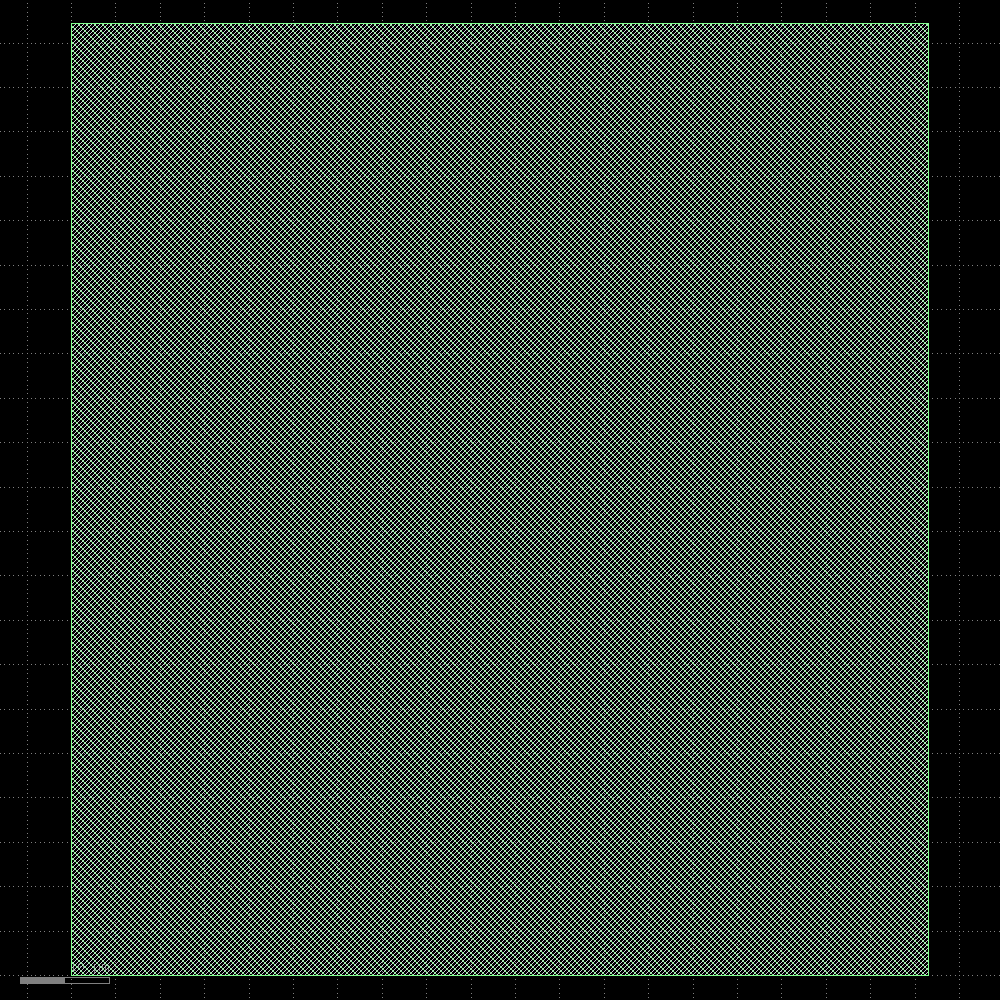

In [47]:
display(floorplan)

### Tap/Endcap Cell Insertion

This places two kinds of cells on the floorplan:

* End cap/boundary cells: Added at the beginning and end of each row. True to
  their name, they "cap off" the core area of a design.
* Tap cells: Placed in a polka dot-ish fashion across the rows. Tap cells
  connect VDD to the nwell and the psubstrate to VSS, which the majority of cells
  do not do themselves to save area- but if you go long enough without one such
  connection you end up with the cell "latching-up"; i.e.; refusing to switch
  back to LO from HI.

  There is a maximum distance between tap cells enforced as part of every
  foundry process.

In [48]:
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

[05:35:34] VERBOSE  Running 'OpenROAD.TapEndcapInsertion'…                                             ]8;id=381180;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=44759;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:35:34] VERBOSE  Logging subprocess to                                                              ]8;id=930597;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=572656;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=223458;file:///content/openlane_run/20-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\openlane_run/]8;;\]8;id=468106;file:///content/openlane_run/20-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\20]8;;\]8;id=223458;file:///content/openlane_run/20-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log\-openroad-tapendcapinsertion/openroad-tapendcapinsertion.log]8;;\…                   

Reading OpenROAD database at '/content/openlane_run/19-openroad-floorplan/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO TAP-0004] Inserted 62 endcaps.

[INFO TAP-0005] Inserted 99 tapcells.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/20-openroad-tapendcapinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/20-openroad-tapendcapinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/20-openroad-tapendcapinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/20-openroad-tapendcapinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/20-openroad-tapendcapinsertion/spm.sdc'…

{'nl': Path('/content/openlane_run/20-openroad-tapendcapinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/20-openroad-tapendcapinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/20-openroad-tapendcapinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/20-openroad-tapendcapinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/20-openroad-tapendcapinsertion/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 36, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591')}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:35:39] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=265377;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=101143;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:35:39] VERBOSE  Logging subprocess to ]8;id=838384;file:///tmp/openlane_klayout_tmp_1n_9cbex/klayout-render.log\..]8;;\]8;id=331928;file:///tmp/openlane_klayout_tmp_1n_9cbex/klayout-render.log\/tmp/openlane_klayout_tmp_1n_9cbex/]8;;\]8;id=32916;file:///tmp/openlane_klayout_tmp_1n_9cbex/klayout-render.log\klayout-render.log]8;;\…     ]8;id=767893;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=91093;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.82s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
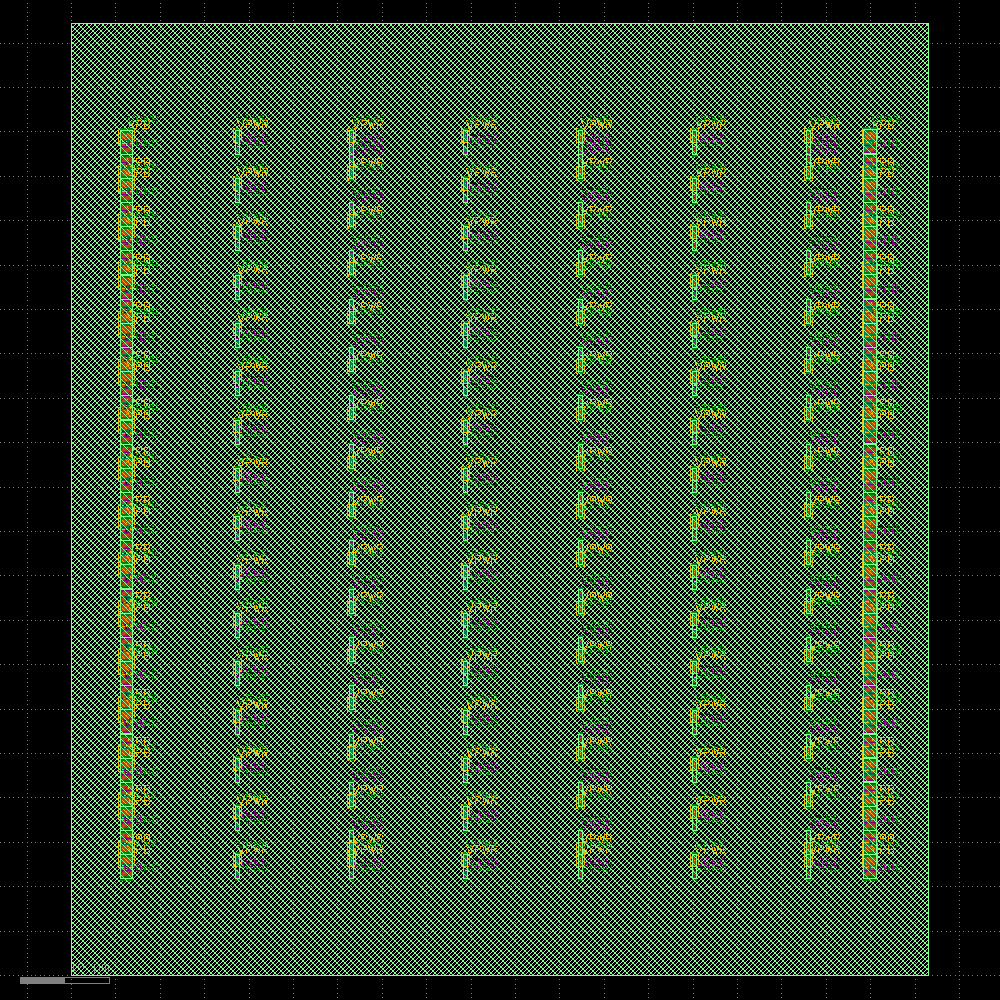

In [49]:
display(tdi)

### I/O Placement

This places metal pins at the edges of the design corresponding to the top level
inputs and outputs for your design. These pins act as the interface with other
designs when you integrate it with other designs.

In [50]:
IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

[05:36:20] VERBOSE  Running 'OpenROAD.IOPlacement'…                                                    ]8;id=800594;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=101284;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:36:20] VERBOSE  Logging subprocess to                                                              ]8;id=560331;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=384461;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=653310;file:///content/openlane_run/21-openroad-ioplacement/openroad-ioplacement.log\openlane_run/]8;;\]8;id=347268;file:///content/openlane_run/21-openroad-ioplacement/openroad-ioplacement.log\21]8;;\]8;id=653310;file:///content/openlane_run/21-openroad-ioplacement/openroad-ioplacement.log\-openroad-ioplacement/openroad-ioplacement.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/20-openroad-tapendcapinsertion/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] place_pins args: -min_distance 3

Found 0 macro blocks.

[INFO PPL-0010] Tentative 0 to set up sections.

[INFO PPL-0001] Number of slots           124

[INFO PPL-0002] Number of I/O             36

[INFO PPL-0003] Number of I/O w/sink      36

[INFO PPL-0004] Number of I/O w/o sink    0

[INFO PPL-0005] Slots per section         200

[INFO PPL-0006] Slots increase factor     0.01

[INFO PPL-0008] Successfully assigned pins to sections.

[INFO PPL-0012] I/O nets HPWL: 2621.62 um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/21-openroad-ioplacement/spm.odb'…

Writing netlist to '/content/openlane_run/21-openroad-ioplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/21-openroad-ioplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/21-openroad-ioplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/21-openroad-ioplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/21-openroad-ioplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/21-openroad-ioplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/21-openroad-ioplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/21-openroad-ioplacement/spm.odb'), 'sdc': Path('/content/openlane_run/21-openroad-ioplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 36, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:36:24] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=541971;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=861856;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:36:24] VERBOSE  Logging subprocess to ]8;id=494672;file:///tmp/openlane_klayout_tmp_3_027g12/klayout-render.log\..]8;;\]8;id=915652;file:///tmp/openlane_klayout_tmp_3_027g12/klayout-render.log\/tmp/openlane_klayout_tmp_3_027g12/]8;;\]8;id=440855;file:///tmp/openlane_klayout_tmp_3_027g12/klayout-render.log\klayout-render.log]8;;\…     ]8;id=932475;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=536444;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.82s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
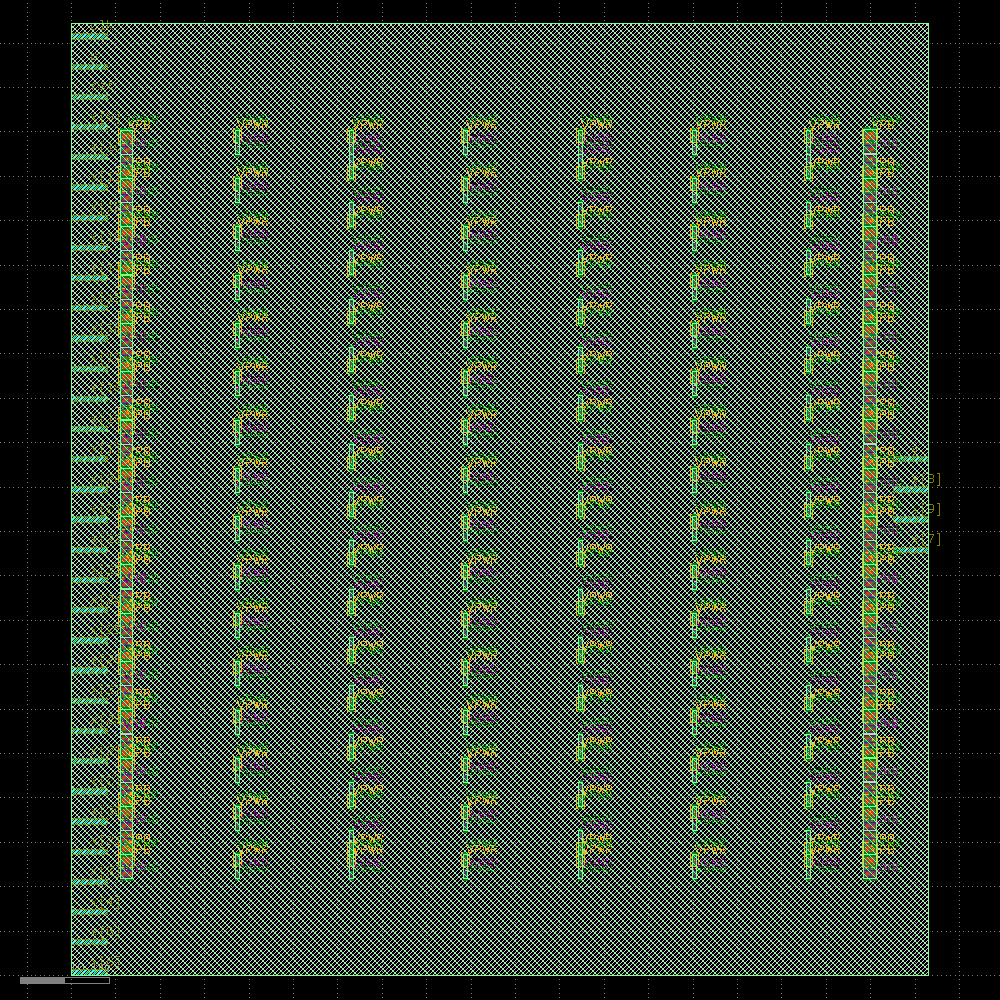

In [51]:
display(ioplace)

### Generating the Power Distribution Network (PDN)

This creates the power distribution network for your design, which is essentially
a plaid pattern of horizontal and vertical "straps" across the design that is
then connected to the rails' VDD and VSS (via the tap cells.)

You can find an explanation of how the power distribution network works at this
link: https://openlane2.readthedocs.io/en/latest/usage/hardening_macros.html#pdn-generation

While we typically don't need to mess with the PDN too much, the SPM is a small
design, so we're going to need to make the plaid pattern formed by the PDN a bit
smaller.

In [52]:
GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

[05:36:57] VERBOSE  Running 'OpenROAD.GeneratePDN'…                                                    ]8;id=28810;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=392553;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:36:57] INFO     'FP_PDN_CFG' not explicitly set, setting it to                                 ]8;id=370004;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=929998;file:///content/openlane_ipynb/openlane/steps/openroad.py#1174\1174]8;;\
                    /content/openlane_ipynb/openlane/scripts/openroad/common/pdn_cfg.tcl…                          

[05:36:57] VERBOSE  Logging subprocess to                                                              ]8;id=769722;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=306861;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=853996;file:///content/openlane_run/22-openroad-generatepdn/openroad-generatepdn.log\openlane_run/]8;;\]8;id=850072;file:///content/openlane_run/22-openroad-generatepdn/openroad-generatepdn.log\22]8;;\]8;id=853996;file:///content/openlane_run/22-openroad-generatepdn/openroad-generatepdn.log\-openroad-generatepdn/openroad-generatepdn.log]8;;\…                                 

Reading OpenROAD database at '/content/openlane_run/21-openroad-ioplacement/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting global connections...

[INFO PDN-0001] Inserting grid: stdcell_grid

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/22-openroad-generatepdn/spm.odb'…

Writing netlist to '/content/openlane_run/22-openroad-generatepdn/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/22-openroad-generatepdn/spm.pnl.v'…

Writing layout to '/content/openlane_run/22-openroad-generatepdn/spm.def'…

Writing timing constraints to '/content/openlane_run/22-openroad-generatepdn/spm.sdc'…

[INFO PSM-0040] All shapes on net VPWR are connected.

[INFO PSM-0040] All shapes on net VGND are connected.

{'nl': Path('/content/openlane_run/22-openroad-generatepdn/spm.nl.v'), 'pnl': Path('/content/openlane_run/22-openroad-generatepdn/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/22-openroad-generatepdn/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/22-openroad-generatepdn/spm.odb'), 'sdc': Path('/content/openlane_run/22-openroad-generatepdn/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:37:01] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=804133;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=812452;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:37:01] VERBOSE  Logging subprocess to ]8;id=441203;file:///tmp/openlane_klayout_tmp_hjul2aqm/klayout-render.log\..]8;;\]8;id=792207;file:///tmp/openlane_klayout_tmp_hjul2aqm/klayout-render.log\/tmp/openlane_klayout_tmp_hjul2aqm/]8;;\]8;id=708204;file:///tmp/openlane_klayout_tmp_hjul2aqm/klayout-render.log\klayout-render.log]8;;\…     ]8;id=846823;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=705212;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.93s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
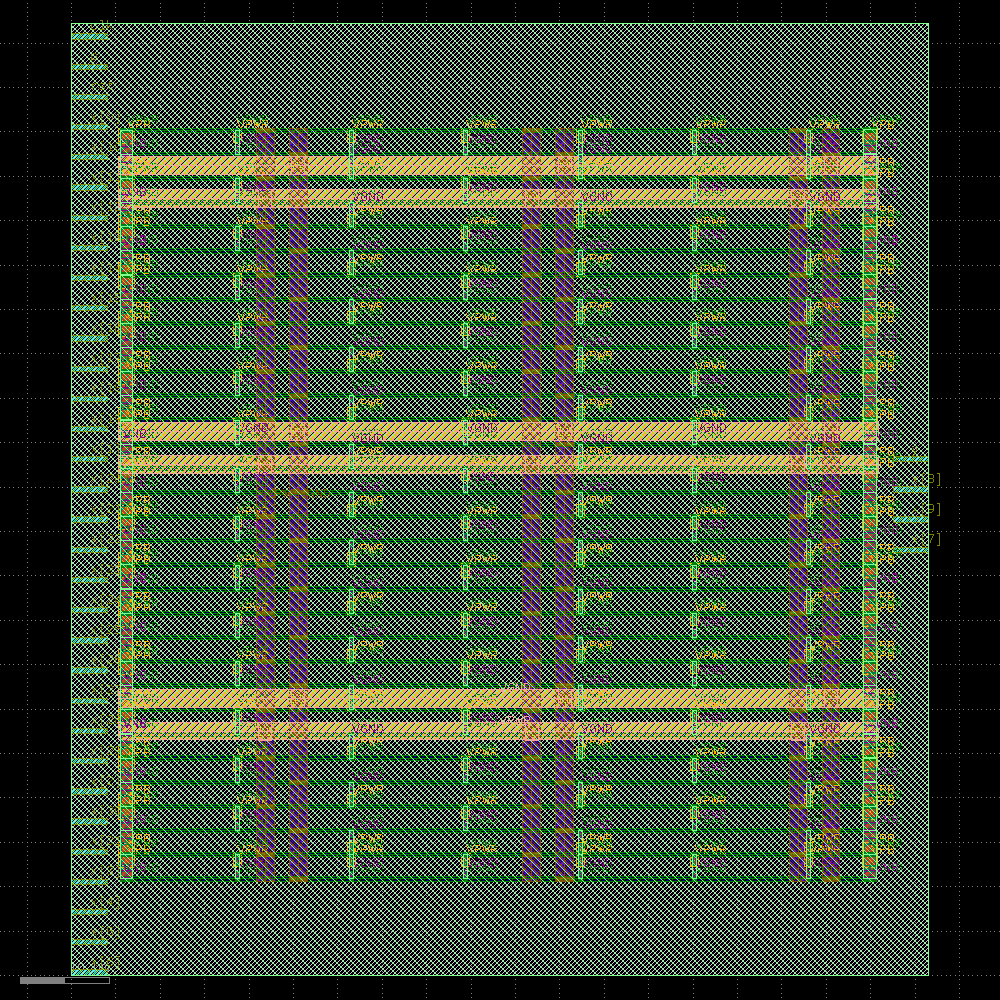

In [53]:
display(pdn)

### Global Placement

Global Placement is deciding on a fuzzy, non-final location for each of the cells,
with the aim of minimizing the distance between cells that are connected
together (more specifically, the total length of the not-yet-created wires that
will connect them).

As you will see in the `.display()` in the second cell below, the placement is
considered "illegal", i.e., not properly aligned with the cell placement grid.
This is addressed by "Detailed Placement", also referred to as "placement
legalization", which is the next step.

In [54]:
GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

[05:37:43] VERBOSE  Running 'OpenROAD.GlobalPlacement'…                                                ]8;id=54057;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=573239;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:37:43] INFO     'PL_TARGET_DENSITY_PCT' not explicitly set, using dynamically calculated       ]8;id=346908;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=224080;file:///content/openlane_ipynb/openlane/steps/openroad.py#1260\1260]8;;\
                    target density: 62.659100…                                                                     

[05:37:43] VERBOSE  Logging subprocess to                                                              ]8;id=632077;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=991186;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=864636;file:///content/openlane_run/23-openroad-globalplacement/openroad-globalplacement.log\openlane_run/]8;;\]8;id=304457;file:///content/openlane_run/23-openroad-globalplacement/openroad-globalplacement.log\23]8;;\]8;id=864636;file:///content/openlane_run/23-openroad-globalplacement/openroad-globalplacement.log\-openroad-globalplacement/openroad-globalplacement.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/22-openroad-generatepdn/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

[INFO GPL-0002] DBU: 1000

[INFO GPL-0003] SiteSize: (  0.460  2.720 ) um

[INFO GPL-0004] CoreBBox: (  5.520 10.880 ) ( 90.620 95.200 ) um

[INFO GPL-0006] NumInstances:               447

[INFO GPL-0007] NumPlaceInstances:          286

[INFO GPL-0008] NumFixedInstances:          161

[INFO GPL-0009] NumDummyInstances:            0

[INFO GPL-0010] NumNets:                    321

[INFO GPL-0011] NumPins:                    958

[INFO GPL-0012] DieBBox:  (  0.000  0.000 ) ( 96.535 107.255 ) um

[INFO GPL-0013] CoreBBox: (  5.520 10.880 ) ( 90.620 95.200 ) um

[INFO GPL-0016] CoreArea:              7175.632 um^2

[INFO GPL-0017] NonPlaceInstsArea:      356.592 um^2

[INFO GPL-0018] PlaceInstsArea:        3654.755 um^2

[INFO GPL-0019] Util:                    53.596 %

[INFO GPL-0020] StdInstsArea:          3654.755 um^2

[INFO GPL-0021] MacroInstsArea:           0.000 um^2

[InitialPlace]  Iter: 1 CG residual: 0.00000011 HPWL: 5542300

[InitialPlace]  Iter: 2 CG residual: 0.00000011 HPWL: 4832507

[InitialPlace]  Iter: 3 CG residual: 0.00000004 HPWL: 4599321

[InitialPlace]  Iter: 4 CG residual: 0.00000011 HPWL: 4534012

[InitialPlace]  Iter: 5 CG residual: 0.00000009 HPWL: 4511736

[INFO GPL-0031] FillerInit:NumGCells:       335

[INFO GPL-0032] FillerInit:NumGNets:        321

[INFO GPL-0033] FillerInit:NumGPins:        958

[INFO GPL-0023] TargetDensity:            0.627

[INFO GPL-0024] AvrgPlaceInstArea:       12.779 um^2

[INFO GPL-0025] IdealBinArea:            20.394 um^2

[INFO GPL-0026] IdealBinCnt:                351

[INFO GPL-0027] TotalBinArea:          7175.632 um^2

[INFO GPL-0028] BinCnt:        16     16

[INFO GPL-0029] BinSize: (  5.319  5.270 )

[INFO GPL-0030] NumBins: 256

[NesterovSolve] Iter:    1 overflow: 0.824 HPWL: 2052447

[NesterovSolve] Iter:   10 overflow: 0.788 HPWL: 2151962

[INFO GPL-0100] worst slack 6.66e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter:   20 overflow: 0.765 HPWL: 2189570

[NesterovSolve] Iter:   30 overflow: 0.766 HPWL: 2187464

[NesterovSolve] Iter:   40 overflow: 0.773 HPWL: 2174877

[NesterovSolve] Iter:   50 overflow: 0.769 HPWL: 2178008

[NesterovSolve] Iter:   60 overflow: 0.768 HPWL: 2181889

[NesterovSolve] Iter:   70 overflow: 0.769 HPWL: 2178980

[NesterovSolve] Iter:   80 overflow: 0.769 HPWL: 2177669

[NesterovSolve] Iter:   90 overflow: 0.767 HPWL: 2178157

[NesterovSolve] Iter:  100 overflow: 0.767 HPWL: 2176547

[NesterovSolve] Iter:  110 overflow: 0.765 HPWL: 2173792

[NesterovSolve] Iter:  120 overflow: 0.762 HPWL: 2171951

[NesterovSolve] Iter:  130 overflow: 0.758 HPWL: 2169764

[NesterovSolve] Iter:  140 overflow: 0.752 HPWL: 2168616

[NesterovSolve] Iter:  150 overflow: 0.742 HPWL: 2163236

[NesterovSolve] Iter:  160 overflow: 0.724 HPWL: 2154633

[NesterovSolve] Iter:  170 overflow: 0.713 HPWL: 2180778

[NesterovSolve] Iter:  180 overflow: 0.700 HPWL: 2216838

[NesterovSolve] Iter:  190 overflow: 0.660 HPWL: 2289818

[INFO GPL-0100] worst slack 6.63e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter:  200 overflow: 0.627 HPWL: 2375546

[NesterovSolve] Snapshot saved at iter = 202

[NesterovSolve] Iter:  210 overflow: 0.573 HPWL: 2420258

[NesterovSolve] Iter:  220 overflow: 0.527 HPWL: 2514472

[INFO GPL-0100] worst slack 6.61e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter:  230 overflow: 0.458 HPWL: 2585636

[NesterovSolve] Iter:  240 overflow: 0.403 HPWL: 2626328

[NesterovSolve] Iter:  250 overflow: 0.354 HPWL: 2684941

[NesterovSolve] Iter:  260 overflow: 0.338 HPWL: 2710570

[NesterovSolve] Iter:  270 overflow: 0.317 HPWL: 2715465

[NesterovSolve] Iter:  280 overflow: 0.295 HPWL: 2753234

[INFO GPL-0100] worst slack 6.57e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter:  290 overflow: 0.282 HPWL: 2771830

[NesterovSolve] Iter:  300 overflow: 0.266 HPWL: 2788007

[NesterovSolve] Iter:  310 overflow: 0.251 HPWL: 2804752

[NesterovSolve] Iter:  320 overflow: 0.235 HPWL: 2834291

[NesterovSolve] Iter:  330 overflow: 0.216 HPWL: 2876494

[INFO GPL-0100] worst slack 6.55e-09

[INFO GPL-0103] Weighted 31 nets.

[INFO GPL-0075] Routability numCall: 1 inflationIterCnt: 1 bloatIterCnt: 0

[INFO GPL-0036] TileBBox: (    0    0 ) ( 6900 6900 ) DBU

[INFO GPL-0038] TileCnt:      13   15

[INFO GPL-0039] numRoutingLayers: 6

[INFO GPL-0040] NumTiles: 195

[INFO GPL-0063] TotalRouteOverflowH2: 0

[INFO GPL-0064] TotalRouteOverflowV2: 0

[INFO GPL-0065] OverflowTileCnt2: 0

[INFO GPL-0066] 0.5%RC: 1.0000

[INFO GPL-0067] 1.0%RC: 0.9750

[INFO GPL-0068] 2.0%RC: 0.9455

[INFO GPL-0069] 5.0%RC: 0.8833

[INFO GPL-0070] 0.5rcK: 1

[INFO GPL-0071] 1.0rcK: 1

[INFO GPL-0072] 2.0rcK: 0

[INFO GPL-0073] 5.0rcK: 0

[INFO GPL-0074] FinalRC: 0.9875

[INFO GPL-0077] FinalRC lower than targetRC(1), routability not needed.

[NesterovSolve] Iter:  340 overflow: 0.189 HPWL: 2902328

[NesterovSolve] Iter:  350 overflow: 0.166 HPWL: 2925141

[NesterovSolve] Iter:  360 overflow: 0.144 HPWL: 2956636

[INFO GPL-0100] worst slack 6.55e-09

[INFO GPL-0103] Weighted 31 nets.

[NesterovSolve] Iter:  370 overflow: 0.114 HPWL: 2982186

[NesterovSolve] Finished with Overflow: 0.098805

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/23-openroad-globalplacement/spm.odb'…

Writing netlist to '/content/openlane_run/23-openroad-globalplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/23-openroad-globalplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/23-openroad-globalplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/23-openroad-globalplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/23-openroad-globalplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/23-openroad-globalplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/23-openroad-globalplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/23-openroad-globalplacement/spm.odb'), 'sdc': Path('/content/openlane_run/23-openroad-globalplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:37:52] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=800367;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=390659;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:37:52] VERBOSE  Logging subprocess to ]8;id=584781;file:///tmp/openlane_klayout_tmp_q7cua72g/klayout-render.log\..]8;;\]8;id=901930;file:///tmp/openlane_klayout_tmp_q7cua72g/klayout-render.log\/tmp/openlane_klayout_tmp_q7cua72g/]8;;\]8;id=274990;file:///tmp/openlane_klayout_tmp_q7cua72g/klayout-render.log\klayout-render.log]8;;\…     ]8;id=256519;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=139741;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 2.24s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
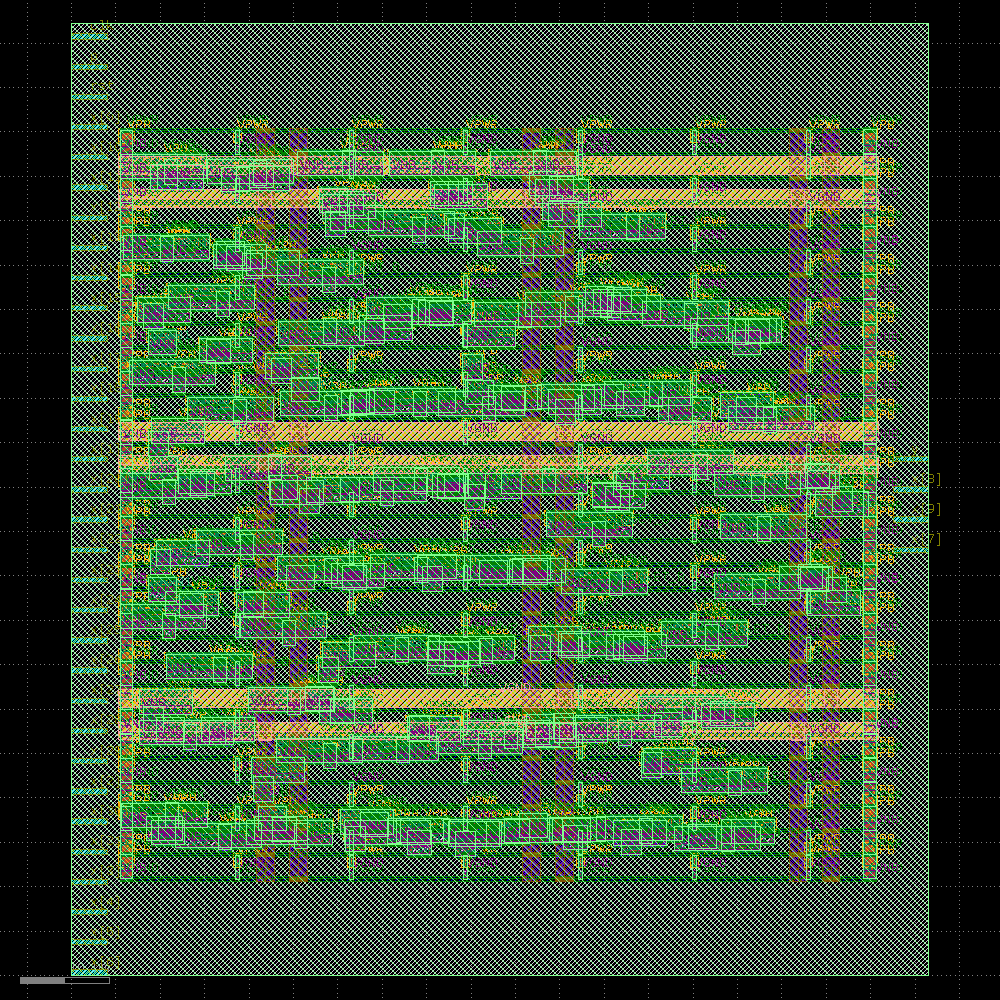

In [55]:
display(gpl)

### Detailed Placement

This aligns the fuzzy placement from before with the grid, "legalizing" it.

In [56]:
DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

[05:38:27] VERBOSE  Running 'OpenROAD.DetailedPlacement'…                                              ]8;id=965705;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=932568;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:38:27] VERBOSE  Logging subprocess to                                                              ]8;id=122351;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=801361;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=118761;file:///content/openlane_run/24-openroad-detailedplacement/openroad-detailedplacement.log\openlane_run/]8;;\]8;id=90499;file:///content/openlane_run/24-openroad-detailedplacement/openroad-detailedplacement.log\24]8;;\]8;id=118761;file:///content/openlane_run/24-openroad-detailedplacement/openroad-detailedplacement.log\-openroad-detailedplacement/openroad-detailedplacement.log]8;;\…                     

Reading OpenROAD database at '/content/openlane_run/23-openroad-globalplacement/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

Placement Analysis

---------------------------------

total displacement        795.9 u

average displacement        1.8 u

max displacement            8.3 u

original HPWL            3036.3 u

legalized HPWL           4089.9 u

delta HPWL                   35 %

[INFO DPL-0020] Mirrored 106 instances

[INFO DPL-0021] HPWL before            4089.9 u

[INFO DPL-0022] HPWL after             3861.5 u

[INFO DPL-0023] HPWL delta               -5.6 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/24-openroad-detailedplacement/spm.odb'…

Writing netlist to '/content/openlane_run/24-openroad-detailedplacement/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/24-openroad-detailedplacement/spm.pnl.v'…

Writing layout to '/content/openlane_run/24-openroad-detailedplacement/spm.def'…

Writing timing constraints to '/content/openlane_run/24-openroad-detailedplacement/spm.sdc'…

{'nl': Path('/content/openlane_run/24-openroad-detailedplacement/spm.nl.v'), 'pnl': Path('/content/openlane_run/24-openroad-detailedplacement/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/24-openroad-detailedplacement/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/24-openroad-detailedplacement/spm.odb'), 'sdc': Path('/content/openlane_run/24-openroad-detailedplacement/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 385, 'design__instance__area': Decimal('3778.62'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 385, 'design__instance__area__stdcell': Decimal('3778.62'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.526591'), 'design__instance__utilization__stdcell': Decimal('0.526591'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('795.863'), 'design__instance__displacement__mean': Decimal('1.78'), 'design__instance__displacement__max': Decimal('8.253'), 'route__wirelength__estimated': Decimal('4089.88'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:38:31] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=950132;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=413624;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:38:31] VERBOSE  Logging subprocess to ]8;id=921125;file:///tmp/openlane_klayout_tmp_9snquvg1/klayout-render.log\..]8;;\]8;id=991658;file:///tmp/openlane_klayout_tmp_9snquvg1/klayout-render.log\/tmp/openlane_klayout_tmp_9snquvg1/]8;;\]8;id=167898;file:///tmp/openlane_klayout_tmp_9snquvg1/klayout-render.log\klayout-render.log]8;;\…     ]8;id=774655;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=1718;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
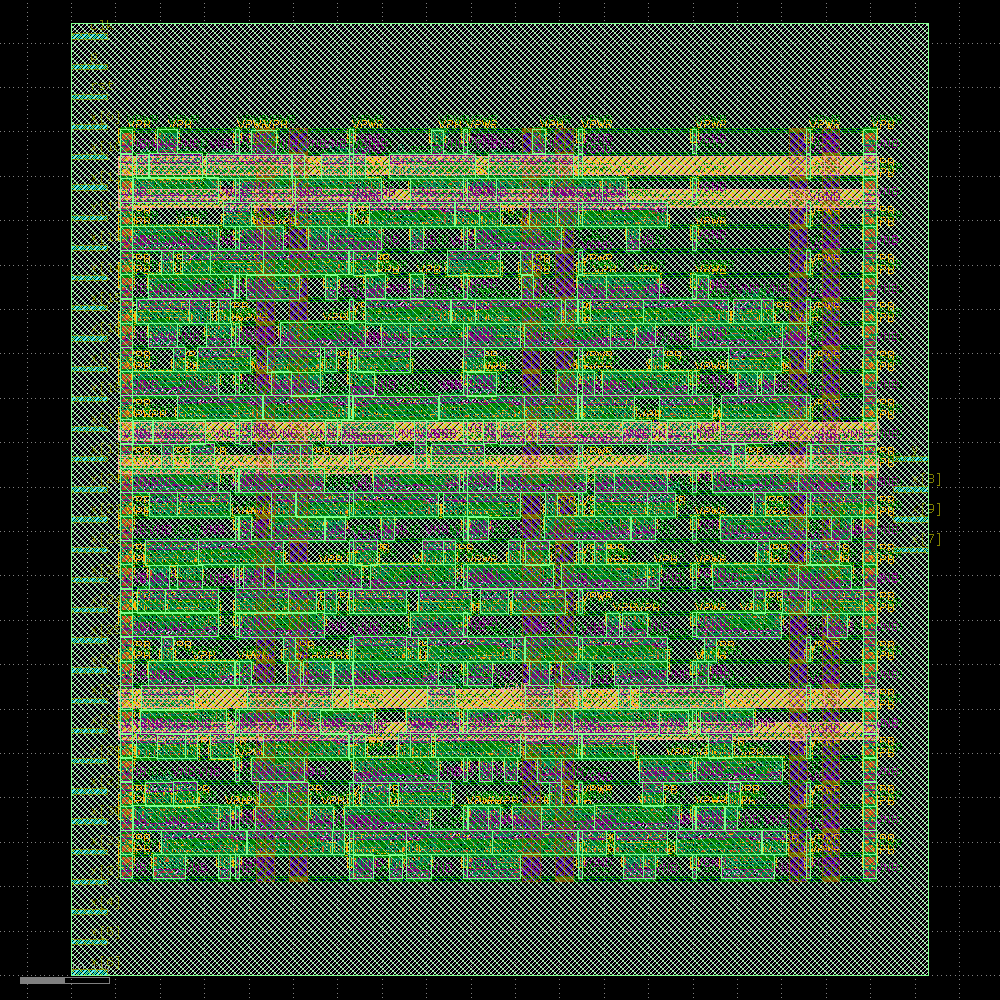

In [57]:
display(dpl)

### Clock Tree Synthesis (CTS)

With the cells now having a final placement, we can go ahead and create what
is known as the clock tree, i.e., the hierarchical set of buffers used
for clock signal to minimize what is known as "clock skew"- variable delay
of the clock cycle from register to register because of factors such as metal
wire length, clock load (number of gates connected to the same clock buffer,)
et cetera.

The CTS step creates the cells and places the between the gaps in the detailed
placement above.

In [58]:
CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

[05:38:49] VERBOSE  Running 'OpenROAD.CTS'…                                                            ]8;id=542238;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=659551;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:38:49] VERBOSE  Logging subprocess to ]8;id=106136;file:///content/openlane_run/25-openroad-cts/openroad-cts.log\openlane_run/]8;;\]8;id=295564;file:///content/openlane_run/25-openroad-cts/openroad-cts.log\25]8;;\]8;id=106136;file:///content/openlane_run/25-openroad-cts/openroad-cts.log\-openroad-cts/openroad-cts.log]8;;\…               ]8;id=110125;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=478527;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Reading timing models for corner nom_tt_025C_1v80…

Reading timing library for the 'nom_tt_025C_1v80' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading timing models for corner nom_ff_n40C_1v95…

Reading timing library for the 'nom_ff_n40C_1v95' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ff_n40C_1v95.lib'…

Reading timing models for corner nom_ss_100C_1v60…

Reading timing library for the 'nom_ss_100C_1v60' corner at                                                        
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__ss_100C_1v60.lib'…

Reading OpenROAD database at '/content/openlane_run/24-openroad-detailedplacement/spm.odb'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting RC values…

[INFO] Configuring cts characterization…

[INFO] Performing clock tree synthesis…

[INFO] Looking for the following net(s): clk

[INFO] Running Clock Tree Synthesis…

[INFO CTS-0050] Root buffer is sky130_fd_sc_hd__clkbuf_16.

[INFO CTS-0051] Sink buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0052] The following clock buffers will be used for CTS:

sky130_fd_sc_hd__clkbuf_2

sky130_fd_sc_hd__clkbuf_4

sky130_fd_sc_hd__clkbuf_8

[INFO CTS-0049] Characterization buffer is sky130_fd_sc_hd__clkbuf_8.

[INFO CTS-0007] Net "clk" found for clock "clk".

[INFO CTS-0010]  Clock net "clk" has 64 sinks.

[INFO CTS-0008] TritonCTS found 1 clock nets.

[INFO CTS-0097] Characterization used 3 buffer(s) types.

[INFO CTS-0200] 0 placement blockages have been identified.

[INFO CTS-0201] 0 placed hard macros will be treated like blockages.

[INFO CTS-0027] Generating H-Tree topology for net clk.

[INFO CTS-0028]  Total number of sinks: 64.

[INFO CTS-0029]  Sinks will be clustered in groups of up to 25 and with maximum cluster diameter of 50.0 um.

[INFO CTS-0030]  Number of static layers: 0.

[INFO CTS-0020]  Wire segment unit: 13600  dbu (13 um).

[INFO CTS-0023]  Original sink region: [(7165, 15020), (79775, 91180)].

[INFO CTS-0024]  Normalized sink region: [(0.526838, 1.10441), (5.86581, 6.70441)].

[INFO CTS-0025]     Width:  5.3390.

[INFO CTS-0026]     Height: 5.6000.

Level 1

Direction: Vertical

Sinks per sub-region: 32

Sub-region size: 5.3390 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Level 2

Direction: Horizontal

Sinks per sub-region: 16

Sub-region size: 2.6695 X 2.8000

[INFO CTS-0034]     Segment length (rounded): 1.

Level 3

Direction: Vertical

Sinks per sub-region: 8

Sub-region size: 2.6695 X 1.4000

[INFO CTS-0034]     Segment length (rounded): 1.

[INFO CTS-0032]  Stop criterion found. Max number of sinks is 15.

[INFO CTS-0035]  Number of sinks covered: 64.

[INFO CTS-0018]     Created 9 clock buffers.

[INFO CTS-0012]     Minimum number of buffers in the clock path: 2.

[INFO CTS-0013]     Maximum number of buffers in the clock path: 2.

[INFO CTS-0015]     Created 9 clock nets.

[INFO CTS-0016]     Fanout distribution for the current clock = 7:2, 8:4, 9:2..

[INFO CTS-0017]     Max level of the clock tree: 3.

[INFO CTS-0098] Clock net "clk"

[INFO CTS-0099]  Sinks 70

[INFO CTS-0100]  Leaf buffers 0

[INFO CTS-0101]  Average sink wire length 144.34 um

[INFO CTS-0102]  Path depth 2 - 2

[INFO CTS-0207]  Leaf load cells 6

[INFO] Repairing long wires on clock nets…

[INFO RSZ-0058] Using max wire length 6335um.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/25-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/25-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/25-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/25-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/25-openroad-cts/spm.sdc'…

[INFO] Legalizing…

Placement Analysis

---------------------------------

total displacement        110.9 u

average displacement        0.2 u

max displacement            7.0 u

original HPWL            4237.7 u

legalized HPWL           4604.3 u

delta HPWL                    9 %

[INFO DPL-0020] Mirrored 107 instances

[INFO DPL-0021] HPWL before            4604.3 u

[INFO DPL-0022] HPWL after             4347.5 u

[INFO DPL-0023] HPWL delta               -5.6 %

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/25-openroad-cts/spm.odb'…

Writing netlist to '/content/openlane_run/25-openroad-cts/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/25-openroad-cts/spm.pnl.v'…

Writing layout to '/content/openlane_run/25-openroad-cts/spm.def'…

Writing timing constraints to '/content/openlane_run/25-openroad-cts/spm.sdc'…

{'nl': Path('/content/openlane_run/25-openroad-cts/spm.nl.v'), 'pnl': Path('/content/openlane_run/25-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/25-openroad-cts/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/25-openroad-cts/spm.odb'), 'sdc': Path('/content/openlane_run/25-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 33696, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__estimated': Decimal('4604.3'), 'design__violations': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:39:01] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=832698;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=252674;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:01] VERBOSE  Logging subprocess to ]8;id=811667;file:///tmp/openlane_klayout_tmp_zgfmiqel/klayout-render.log\..]8;;\]8;id=151509;file:///tmp/openlane_klayout_tmp_zgfmiqel/klayout-render.log\/tmp/openlane_klayout_tmp_zgfmiqel/]8;;\]8;id=202745;file:///tmp/openlane_klayout_tmp_zgfmiqel/klayout-render.log\klayout-render.log]8;;\…     ]8;id=315832;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=947273;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 11.82s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
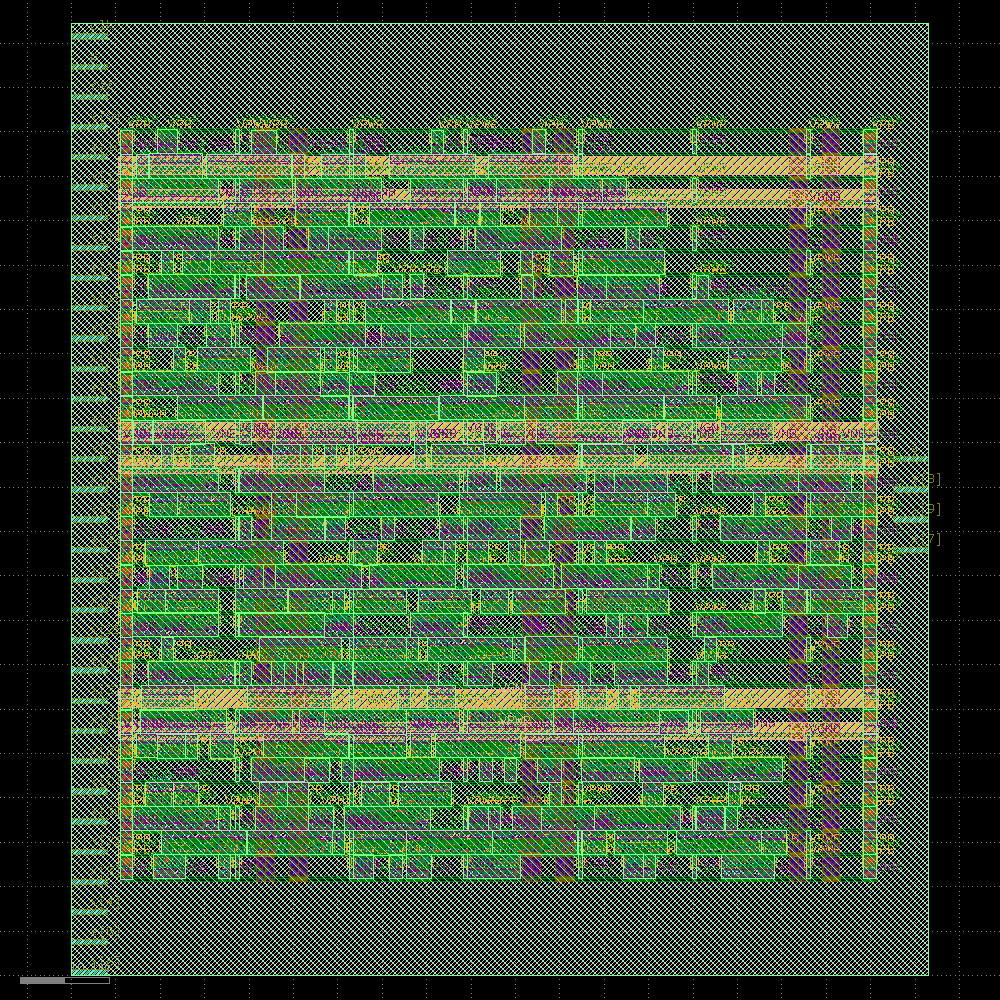

In [59]:
display(cts)

### Global Routing

Global routing "plans" the routes the wires between two gates (or gates and
I/O pins/the PDN) will take. The results of global routing (which are called
"routing guides") are stored in internal data structures and have no effect on
the actual design, so there is no `display()` statement.

In [60]:
GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

[05:39:05] VERBOSE  Running 'OpenROAD.GlobalRouting'…                                                  ]8;id=3160;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=95252;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:05] VERBOSE  Logging subprocess to                                                              ]8;id=944563;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=481062;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=7688;file:///content/openlane_run/26-openroad-globalrouting/openroad-globalrouting.log\openlane_run/]8;;\]8;id=857666;file:///content/openlane_run/26-openroad-globalrouting/openroad-globalrouting.log\26]8;;\]8;id=7688;file:///content/openlane_run/26-openroad-globalrouting/openroad-globalrouting.log\-openroad-globalrouting/openroad-globalrouting.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/25-openroad-cts/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO] Setting signal min routing layer to: met1 and clock min routing layer to met1.

[INFO] Setting signal max routing layer to: met5 and clock max routing layer to met5.

-congestion_iterations 50 -verbose

[INFO GRT-0020] Min routing layer: met1

[INFO GRT-0021] Max routing layer: met5

[INFO GRT-0022] Global adjustment: 30%

[INFO GRT-0023] Grid origin: (0, 0)

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0088] Layer li1     Track-Pitch = 0.4600  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met1    Track-Pitch = 0.3400  line-2-Via Pitch: 0.3400

[INFO GRT-0088] Layer met2    Track-Pitch = 0.4600  line-2-Via Pitch: 0.3500

[INFO GRT-0088] Layer met3    Track-Pitch = 0.6800  line-2-Via Pitch: 0.6150

[INFO GRT-0088] Layer met4    Track-Pitch = 0.9200  line-2-Via Pitch: 1.0400

[INFO GRT-0088] Layer met5    Track-Pitch = 3.4000  line-2-Via Pitch: 3.1100

[INFO GRT-0019] Found 10 clock nets.

[INFO GRT-0001] Minimum degree: 2

[INFO GRT-0002] Maximum degree: 65

[INFO GRT-0003] Macros: 0

[INFO GRT-0043] No OR_DEFAULT vias defined.

[INFO GRT-0004] Blockages: 1206

[INFO GRT-0053] Routing resources analysis:

Routing      Original      Derated      Resource

Layer     Direction    Resources     Resources    Reduction (%)

---------------------------------------------------------------

li1        Vertical            0             0          0.00%

met1       Horizontal       4003          1873          53.21%

met2       Vertical         3165          1951          38.36%

met3       Horizontal       1995          1209          39.40%

met4       Vertical         1302           642          50.69%

met5       Horizontal        399           168          57.89%

---------------------------------------------------------------

[INFO GRT-0197] Via related to pin nodes: 1499

[INFO GRT-0198] Via related Steiner nodes: 18

[INFO GRT-0199] Via filling finished.

[INFO GRT-0111] Final number of vias: 1851

[INFO GRT-0112] Final usage 3D: 6267

[INFO GRT-0096] Final congestion report:

Layer         Resource        Demand        Usage (%)    Max H / Max V / Total Overflow

---------------------------------------------------------------------------------------

li1                  0             0            0.00%             0 /  0 /  0

met1              1873           281           15.00%             0 /  0 /  0

met2              1951           346           17.73%             0 /  0 /  0

met3              1209            87            7.20%             0 /  0 /  0

met4               642             0            0.00%             0 /  0 /  0

met5               168             0            0.00%             0 /  0 /  0

---------------------------------------------------------------------------------------

Total             5843           714           12.22%             0 /  0 /  0

[INFO GRT-0018] Total wirelength: 9459 um

[INFO GRT-0014] Routed nets: 330

[INFO] Setting RC values…

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/26-openroad-globalrouting/spm.odb'…

Writing layout to '/content/openlane_run/26-openroad-globalrouting/spm.def'…

{'nl': Path('/content/openlane_run/25-openroad-cts/spm.nl.v'), 'pnl': Path('/content/openlane_run/25-openroad-cts/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/26-openroad-globalrouting/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/26-openroad-globalrouting/spm.odb'), 'sdc': Path('/content/openlane_run/25-openroad-cts/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__estimated': Decimal('4604.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0}}

### Detailed Routing

Detailed routing uses the guides from Global Routing to actually create wires
on the metal layers and connect the gates, making the connections finally physical.

This is typically the longest step in the flow.

In [61]:
DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

[05:39:10] VERBOSE  Running 'OpenROAD.DetailedRouting'…                                                ]8;id=889970;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=537960;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:10] INFO     Running TritonRoute with 2 threads…                                            ]8;id=694129;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=882872;file:///content/openlane_ipynb/openlane/steps/openroad.py#1619\1619]8;;\

[05:39:10] VERBOSE  Logging subprocess to                                                              ]8;id=18736;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=96257;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=479117;file:///content/openlane_run/27-openroad-detailedrouting/openroad-detailedrouting.log\openlane_run/]8;;\]8;id=199864;file:///content/openlane_run/27-openroad-detailedrouting/openroad-detailedrouting.log\27]8;;\]8;id=479117;file:///content/openlane_run/27-openroad-detailedrouting/openroad-detailedrouting.log\-openroad-detailedrouting/openroad-detailedrouting.log]8;;\…                         

Reading OpenROAD database at '/content/openlane_run/26-openroad-globalrouting/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

[INFO ORD-0030] Using 2 thread(s).

[INFO DRT-0149] Reading tech and libs.

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=707124;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=545114;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=651111;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=363755;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer mcon                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=605760;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=420218;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=453182;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=740727;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via                                                                                      

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=924134;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=353279;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=265510;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=537733;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via2                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=227384;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=206229;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=487045;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=939046;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via3                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=488677;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=47946;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

[05:39:11] WARNING  [DRT-0349] LEF58_ENCLOSURE with no CUTCLASS is not supported. Skipping for      ]8;id=820574;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=201009;file:///content/openlane_ipynb/openlane/steps/openroad.py#235\235]8;;\
                    layer via4                                                                                     

Units:                1000

Number of layers:     13

Number of macros:     441

Number of vias:       29

Number of viarulegen: 25

[INFO DRT-0150] Reading design.

Design:                   spm

Die area:                 ( 0 0 ) ( 96535 107255 )

Number of track patterns: 12

Number of DEF vias:       0

Number of components:     462

Number of terminals:      38

Number of snets:          2

Number of nets:           330

[INFO DRT-0167] List of default vias:

Layer via

default via: M1M2_PR

Layer via2

default via: M2M3_PR

Layer via3

default via: M3M4_PR

Layer via4

default via: M4M5_PR

[INFO DRT-0162] Library cell analysis.

[INFO DRT-0163] Instance analysis.

[INFO DRT-0164] Number of unique instances = 43.

[INFO DRT-0168] Init region query.

[INFO DRT-0024]   Complete FR_MASTERSLICE.

[INFO DRT-0024]   Complete Fr_VIA.

[INFO DRT-0024]   Complete li1.

[INFO DRT-0024]   Complete mcon.

[INFO DRT-0024]   Complete met1.

[INFO DRT-0024]   Complete via.

[INFO DRT-0024]   Complete met2.

[INFO DRT-0024]   Complete via2.

[INFO DRT-0024]   Complete met3.

[INFO DRT-0024]   Complete via3.

[INFO DRT-0024]   Complete met4.

[INFO DRT-0024]   Complete via4.

[INFO DRT-0024]   Complete met5.

[INFO DRT-0033] FR_MASTERSLICE shape region query size = 0.

[INFO DRT-0033] FR_VIA shape region query size = 0.

[INFO DRT-0033] li1 shape region query size = 12461.

[INFO DRT-0033] mcon shape region query size = 0.

[INFO DRT-0033] met1 shape region query size = 2289.

[INFO DRT-0033] via shape region query size = 576.

[INFO DRT-0033] met2 shape region query size = 192.

[INFO DRT-0033] via2 shape region query size = 480.

[INFO DRT-0033] met3 shape region query size = 324.

[INFO DRT-0033] via3 shape region query size = 480.

[INFO DRT-0033] met4 shape region query size = 126.

[INFO DRT-0033] via4 shape region query size = 18.

[INFO DRT-0033] met5 shape region query size = 30.

[INFO DRT-0165] Start pin access.

[INFO DRT-0078]   Complete 108 pins.

[INFO DRT-0081]   Complete 37 unique inst patterns.

[INFO DRT-0084]   Complete 218 groups.

#scanned instances     = 462

#unique  instances     = 43

#stdCellGenAp          = 1063

#stdCellValidPlanarAp  = 44

#stdCellValidViaAp     = 726

#stdCellPinNoAp        = 0

#stdCellPinCnt         = 946

#instTermValidViaApCnt = 0

#macroGenAp            = 0

#macroValidPlanarAp    = 0

#macroValidViaAp       = 0

#macroNoAp             = 0

[INFO DRT-0166] Complete pin access.

[INFO DRT-0267] cpu time = 00:00:10, elapsed time = 00:00:08, memory = 116.26 (MB), peak = 246.44 (MB)

Number of guides:     2037

[INFO DRT-0169] Post process guides.

[INFO DRT-0176] GCELLGRID X 0 DO 13 STEP 6900 ;

[INFO DRT-0177] GCELLGRID Y 0 DO 15 STEP 6900 ;

[INFO DRT-0028]   Complete FR_MASTERSLICE.

[INFO DRT-0028]   Complete Fr_VIA.

[INFO DRT-0028]   Complete li1.

[INFO DRT-0028]   Complete mcon.

[INFO DRT-0028]   Complete met1.

[INFO DRT-0028]   Complete via.

[INFO DRT-0028]   Complete met2.

[INFO DRT-0028]   Complete via2.

[INFO DRT-0028]   Complete met3.

[INFO DRT-0028]   Complete via3.

[INFO DRT-0028]   Complete met4.

[INFO DRT-0028]   Complete via4.

[INFO DRT-0028]   Complete met5.

[INFO DRT-0178] Init guide query.

[INFO DRT-0035]   Complete FR_MASTERSLICE (guide).

[INFO DRT-0035]   Complete Fr_VIA (guide).

[INFO DRT-0035]   Complete li1 (guide).

[INFO DRT-0035]   Complete mcon (guide).

[INFO DRT-0035]   Complete met1 (guide).

[INFO DRT-0035]   Complete via (guide).

[INFO DRT-0035]   Complete met2 (guide).

[INFO DRT-0035]   Complete via2 (guide).

[INFO DRT-0035]   Complete met3 (guide).

[INFO DRT-0035]   Complete via3 (guide).

[INFO DRT-0035]   Complete met4 (guide).

[INFO DRT-0035]   Complete via4 (guide).

[INFO DRT-0035]   Complete met5 (guide).

[INFO DRT-0036] FR_MASTERSLICE guide region query size = 0.

[INFO DRT-0036] FR_VIA guide region query size = 0.

[INFO DRT-0036] li1 guide region query size = 670.

[INFO DRT-0036] mcon guide region query size = 0.

[INFO DRT-0036] met1 guide region query size = 565.

[INFO DRT-0036] via guide region query size = 0.

[INFO DRT-0036] met2 guide region query size = 280.

[INFO DRT-0036] via2 guide region query size = 0.

[INFO DRT-0036] met3 guide region query size = 36.

[INFO DRT-0036] via3 guide region query size = 0.

[INFO DRT-0036] met4 guide region query size = 0.

[INFO DRT-0036] via4 guide region query size = 0.

[INFO DRT-0036] met5 guide region query size = 0.

[INFO DRT-0179] Init gr pin query.

[INFO DRT-0245] skipped writing guide updates to database.

[INFO DRT-0185] Post process initialize RPin region query.

[INFO DRT-0181] Start track assignment.

[INFO DRT-0184] Done with 950 vertical wires in 1 frboxes and 601 horizontal wires in 1 frboxes.

[INFO DRT-0186] Done with 68 vertical wires in 1 frboxes and 131 horizontal wires in 1 frboxes.

[INFO DRT-0182] Complete track assignment.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 120.97 (MB), peak = 246.44 (MB)

[INFO DRT-0187] Start routing data preparation.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 120.97 (MB), peak = 246.44 (MB)

[INFO DRT-0194] Start detail routing.

[INFO DRT-0195] Start 0th optimization iteration.

Completing 10% with 0 violations.

elapsed time = 00:00:00, memory = 129.84 (MB).

Completing 20% with 0 violations.

elapsed time = 00:00:00, memory = 128.18 (MB).

Completing 30% with 3 violations.

elapsed time = 00:00:01, memory = 130.52 (MB).

Completing 40% with 12 violations.

elapsed time = 00:00:01, memory = 130.52 (MB).

Completing 50% with 12 violations.

elapsed time = 00:00:02, memory = 137.29 (MB).

Completing 60% with 14 violations.

elapsed time = 00:00:03, memory = 142.78 (MB).

[INFO DRT-0199]   Number of violations = 80.

Viol/Layer         li1   met1   met2

Metal Spacing        2     11      2

Min Hole             0      1      0

Recheck              0     42     16

Short                0      5      1

[INFO DRT-0267] cpu time = 00:00:05, elapsed time = 00:00:04, memory = 483.03 (MB), peak = 482.66 (MB)

Total wire length = 5320 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2032 um.

Total wire length on LAYER met2 = 2309 um.

Total wire length on LAYER met3 = 979 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1813.

Up-via summary (total 1813):

-----------------------

FR_MASTERSLICE       0

li1     851

met1     924

met2      38

met3       0

met4       0

-----------------------

1813

[INFO DRT-0195] Start 1st optimization iteration.

Completing 10% with 80 violations.

elapsed time = 00:00:00, memory = 483.03 (MB).

Completing 20% with 80 violations.

elapsed time = 00:00:00, memory = 483.03 (MB).

Completing 30% with 80 violations.

elapsed time = 00:00:00, memory = 485.70 (MB).

Completing 40% with 80 violations.

elapsed time = 00:00:00, memory = 485.70 (MB).

Completing 50% with 73 violations.

elapsed time = 00:00:00, memory = 485.70 (MB).

Completing 60% with 73 violations.

elapsed time = 00:00:01, memory = 485.70 (MB).

Completing 70% with 69 violations.

elapsed time = 00:00:01, memory = 488.02 (MB).

Completing 80% with 69 violations.

elapsed time = 00:00:01, memory = 488.02 (MB).

Completing 90% with 53 violations.

elapsed time = 00:00:02, memory = 488.02 (MB).

Completing 100% with 2 violations.

elapsed time = 00:00:02, memory = 488.02 (MB).

[INFO DRT-0199]   Number of violations = 2.

Viol/Layer        met2

Metal Spacing        1

Short                1

[INFO DRT-0267] cpu time = 00:00:03, elapsed time = 00:00:03, memory = 488.14 (MB), peak = 487.91 (MB)

Total wire length = 5281 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 2006 um.

Total wire length on LAYER met2 = 2293 um.

Total wire length on LAYER met3 = 981 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1815.

Up-via summary (total 1815):

-----------------------

FR_MASTERSLICE       0

li1     851

met1     924

met2      40

met3       0

met4       0

-----------------------

1815

[INFO DRT-0195] Start 2nd optimization iteration.

Completing 10% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 20% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 30% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 40% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 50% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 60% with 2 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 70% with 1 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 80% with 1 violations.

elapsed time = 00:00:00, memory = 488.14 (MB).

Completing 90% with 1 violations.

elapsed time = 00:00:03, memory = 488.14 (MB).

Completing 100% with 1 violations.

elapsed time = 00:00:03, memory = 488.14 (MB).

[INFO DRT-0199]   Number of violations = 1.

Viol/Layer        met1

Short                1

[INFO DRT-0267] cpu time = 00:00:03, elapsed time = 00:00:03, memory = 491.01 (MB), peak = 490.79 (MB)

Total wire length = 5285 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 1991 um.

Total wire length on LAYER met2 = 2308 um.

Total wire length on LAYER met3 = 985 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1815.

Up-via summary (total 1815):

-----------------------

FR_MASTERSLICE       0

li1     851

met1     924

met2      40

met3       0

met4       0

-----------------------

1815

[INFO DRT-0195] Start 3rd optimization iteration.

Completing 10% with 1 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

Completing 20% with 1 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

Completing 30% with 1 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

Completing 40% with 1 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

Completing 50% with 1 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

Completing 60% with 0 violations.

elapsed time = 00:00:00, memory = 491.01 (MB).

[INFO DRT-0199]   Number of violations = 0.

[INFO DRT-0267] cpu time = 00:00:00, elapsed time = 00:00:00, memory = 491.01 (MB), peak = 490.79 (MB)

Total wire length = 5284 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 1986 um.

Total wire length on LAYER met2 = 2312 um.

Total wire length on LAYER met3 = 985 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1819.

Up-via summary (total 1819):

-----------------------

FR_MASTERSLICE       0

li1     851

met1     928

met2      40

met3       0

met4       0

-----------------------

1819

[INFO DRT-0198] Complete detail routing.

Total wire length = 5284 um.

Total wire length on LAYER li1 = 0 um.

Total wire length on LAYER met1 = 1986 um.

Total wire length on LAYER met2 = 2312 um.

Total wire length on LAYER met3 = 985 um.

Total wire length on LAYER met4 = 0 um.

Total wire length on LAYER met5 = 0 um.

Total number of vias = 1819.

Up-via summary (total 1819):

-----------------------

FR_MASTERSLICE       0

li1     851

met1     928

met2      40

met3       0

met4       0

-----------------------

1819

[INFO DRT-0267] cpu time = 00:00:13, elapsed time = 00:00:12, memory = 491.01 (MB), peak = 490.79 (MB)

[INFO DRT-0180] Post processing.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/27-openroad-detailedrouting/spm.odb'…

Writing netlist to '/content/openlane_run/27-openroad-detailedrouting/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/27-openroad-detailedrouting/spm.pnl.v'…

Writing layout to '/content/openlane_run/27-openroad-detailedrouting/spm.def'…

Writing timing constraints to '/content/openlane_run/27-openroad-detailedrouting/spm.sdc'…

{'nl': Path('/content/openlane_run/27-openroad-detailedrouting/spm.nl.v'), 'pnl': Path('/content/openlane_run/27-openroad-detailedrouting/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/27-openroad-detailedrouting/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/27-openroad-detailedrouting/spm.odb'), 'sdc': Path('/content/openlane_run/27-openroad-detailedrouting/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 10, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__estimated': Decimal('4604.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 330, 'route__net__special': 2, 'route__drc_errors__iter:1': 80, 'route__wirelength__iter:1': 5320, 'route__drc_errors__iter:2': 2, 'route__wirelength__iter:2': 5281, 'route__drc_errors__iter:3': 1, 'route__wirelength__iter:3': 5285, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5284, 'route__drc_errors': 0, 'route__wirelength': 5284, 'route__vias': 1819, 'route__vias__singlecut': 1819, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:39:32] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=424889;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=111269;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:32] VERBOSE  Logging subprocess to ]8;id=762932;file:///tmp/openlane_klayout_tmp_jj5bu73p/klayout-render.log\..]8;;\]8;id=591835;file:///tmp/openlane_klayout_tmp_jj5bu73p/klayout-render.log\/tmp/openlane_klayout_tmp_jj5bu73p/]8;;\]8;id=942121;file:///tmp/openlane_klayout_tmp_jj5bu73p/klayout-render.log\klayout-render.log]8;;\…     ]8;id=127472;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=455147;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 21.96s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
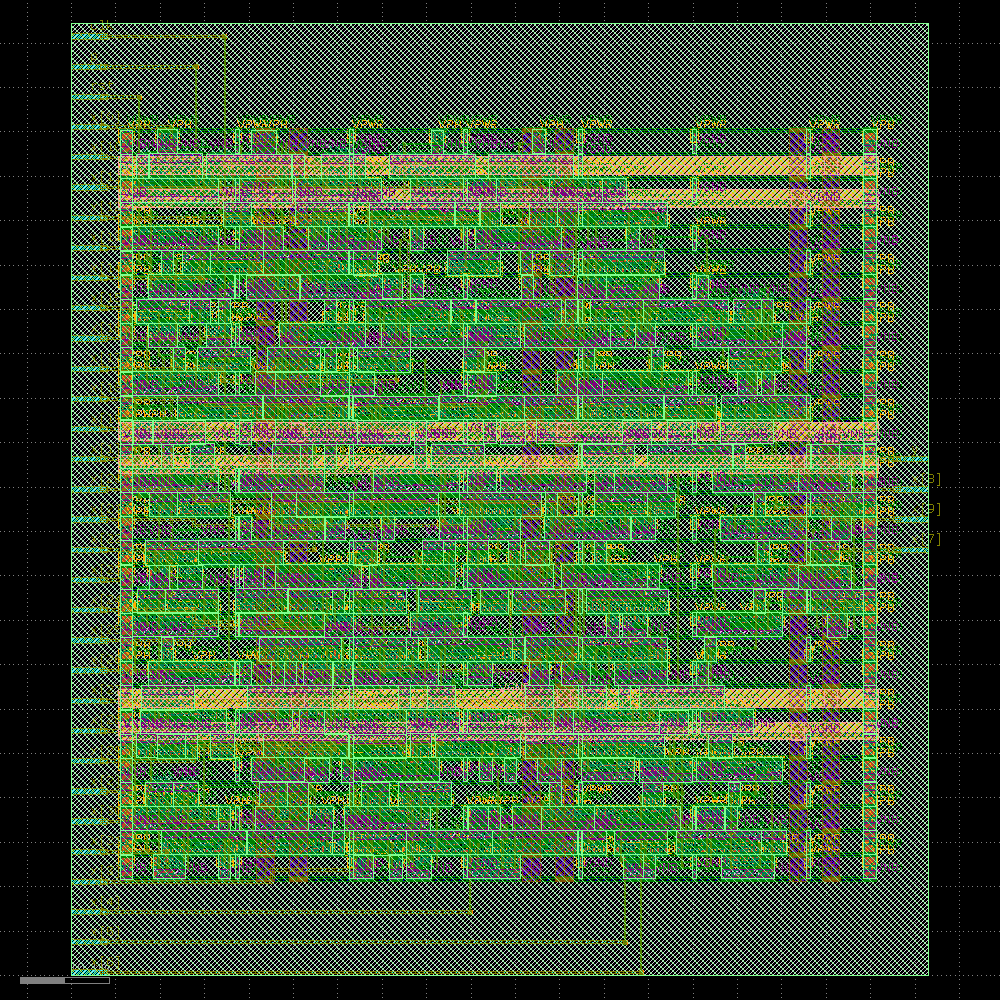

In [62]:
display(drt)

### Fill Insertion

Finally, as we're done placing all the essential cells, the only thing left to
do is fill in the gaps.

We prioritize the use of decap (decoupling capacitor) cells, which
further supports the power distribution network, but when there aren't any
small enough cells, we just use regular fill cells.

In [63]:
FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

[05:39:37] VERBOSE  Running 'OpenROAD.FillInsertion'…                                                  ]8;id=825571;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=78218;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:37] VERBOSE  Logging subprocess to                                                              ]8;id=51636;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=330823;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=72264;file:///content/openlane_run/28-openroad-fillinsertion/openroad-fillinsertion.log\openlane_run/]8;;\]8;id=949435;file:///content/openlane_run/28-openroad-fillinsertion/openroad-fillinsertion.log\28]8;;\]8;id=72264;file:///content/openlane_run/28-openroad-fillinsertion/openroad-fillinsertion.log\-openroad-fillinsertion/openroad-fillinsertion.log]8;;\…                             

Reading OpenROAD database at '/content/openlane_run/27-openroad-detailedrouting/spm.odb'…

Reading library file at '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lib/sky130_fd_sc_hd__tt_025C_1v80.lib'…

Reading design constraints file at '/content/openlane_ipynb/openlane/scripts/base.sdc'…

[INFO] Using clock clk…

[INFO] Setting output delay to: 2

[INFO] Setting input delay to: 2

[INFO] Setting load to: 0.033442

[INFO] Setting clock uncertainty to: 0.25

[INFO] Setting clock transition to: 0.1499999999999999944488848768742172978818416595458984375

[INFO] Setting timing derate to: 5%

sky130_ef_sc_hd__decap_12 sky130_fd_sc_hd__decap_8 sky130_fd_sc_hd__decap_6 sky130_fd_sc_hd__decap_4               
sky130_fd_sc_hd__decap_3 sky130_fd_sc_hd__fill*

[INFO DPL-0001] Placed 431 filler instances.

Setting global connections for newly added cells…

[INFO] Setting global connections...

Writing OpenROAD database to '/content/openlane_run/28-openroad-fillinsertion/spm.odb'…

Writing netlist to '/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'…

Writing powered netlist to '/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'…

Writing layout to '/content/openlane_run/28-openroad-fillinsertion/spm.def'…

Writing timing constraints to '/content/openlane_run/28-openroad-fillinsertion/spm.sdc'…

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': None, 'spef': None, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__estimated': Decimal('4604.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 330, 'route__net__special': 2, 'route__drc_errors__iter:1': 80, 'route__wirelength__iter:1': 5320, 'route__drc_errors__iter:2': 2, 'route__wirelength__iter:2': 5281, 'route__drc_errors__iter:3': 1, 'route__wirelength__iter:3': 5285, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5284, 'route__drc_errors': 0, 'route__wirelength': 5284, 'route__vias': 1819, 'route__vias__singlecut': 1819, 'route__vias__multicut': 0}}

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:39:42] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=658193;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=300081;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:42] VERBOSE  Logging subprocess to ]8;id=734374;file:///tmp/openlane_klayout_tmp_bo2bzwfr/klayout-render.log\..]8;;\]8;id=725309;file:///tmp/openlane_klayout_tmp_bo2bzwfr/klayout-render.log\/tmp/openlane_klayout_tmp_bo2bzwfr/]8;;\]8;id=909490;file:///tmp/openlane_klayout_tmp_bo2bzwfr/klayout-render.log\klayout-render.log]8;;\…     ]8;id=939633;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=521858;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.92s
#### Views updated:
* Verilog Netlist
* Powered Verilog Netlist
* Design Exchange Format
* OpenDB Database
* Design Constraints
#### Preview:
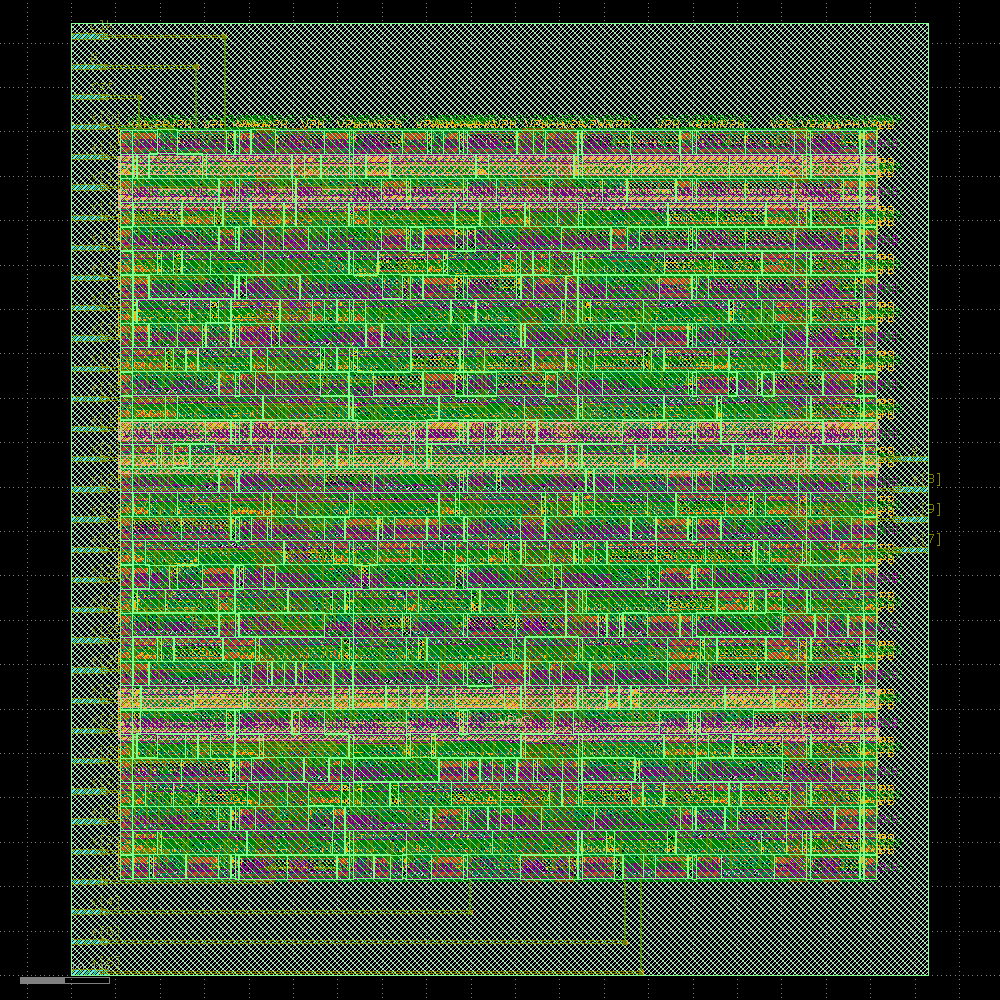

In [64]:
display(fill)

### Parasitics Extraction a.k.a. Resistance/Capacitance Extraction (RCX)

This step does not alter the design- rather, it computes the
[Parasitic elements](https://en.wikipedia.org/wiki/Parasitic_element_(electrical_networks))
of the circuit, which have an effect of timing, as we prepare to do the final
timing analysis.

The parasitic elements are saved in the **Standard Parasitics Exchange Format**,
or SPEF. OpenLane creates a SPEF file for each interconnect corner as described in
the [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
section of the documentation.

In [65]:
RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

[05:39:47] VERBOSE  Running 'OpenROAD.RCX'…                                                            ]8;id=830857;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=364724;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:47] INFO     Running RCX for corners matching nom_*                                         ]8;id=624172;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=115502;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/29-openroad-rcx/nom/rcx.log)…                                           

[05:39:47] INFO     Running RCX for corners matching min_*                                         ]8;id=590567;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=936390;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/29-openroad-rcx/min/rcx.log)…                                           

[05:39:47] VERBOSE  Logging subprocess to ]8;id=249554;file:///content/openlane_run/29-openroad-rcx/nom/rcx.log\openlane_run/]8;;\]8;id=215041;file:///content/openlane_run/29-openroad-rcx/nom/rcx.log\29]8;;\]8;id=249554;file:///content/openlane_run/29-openroad-rcx/nom/rcx.log\-openroad-rcx/nom/rcx.log]8;;\…                    ]8;id=919039;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=579465;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[05:39:47] VERBOSE  Logging subprocess to ]8;id=532082;file:///content/openlane_run/29-openroad-rcx/min/rcx.log\openlane_run/]8;;\]8;id=985704;file:///content/openlane_run/29-openroad-rcx/min/rcx.log\29]8;;\]8;id=532082;file:///content/openlane_run/29-openroad-rcx/min/rcx.log\-openroad-rcx/min/rcx.log]8;;\…                    ]8;id=791041;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=282547;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[05:39:48] INFO     Finished RCX for corners matching nom_*.                                       ]8;id=159983;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=418709;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[05:39:48] INFO     Running RCX for corners matching max_*                                         ]8;id=344883;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=975457;file:///content/openlane_ipynb/openlane/steps/openroad.py#1748\1748]8;;\
                    (/content/openlane_run/29-openroad-rcx/max/rcx.log)…                                           

[05:39:48] VERBOSE  Logging subprocess to ]8;id=390178;file:///content/openlane_run/29-openroad-rcx/max/rcx.log\openlane_run/]8;;\]8;id=600395;file:///content/openlane_run/29-openroad-rcx/max/rcx.log\29]8;;\]8;id=390178;file:///content/openlane_run/29-openroad-rcx/max/rcx.log\-openroad-rcx/max/rcx.log]8;;\…                    ]8;id=284325;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=251261;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[05:39:48] INFO     Finished RCX for corners matching min_*.                                       ]8;id=771020;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=741373;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

[05:39:49] INFO     Finished RCX for corners matching max_*.                                       ]8;id=154328;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=270519;file:///content/openlane_ipynb/openlane/steps/openroad.py#1757\1757]8;;\

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': None, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': None, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 0, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__estimated': Decimal('4604.3'), 'design__violations': 0, 'antenna__violating__nets': 0, 'antenna__violating__pins': 0, 'route__net': 330, 'route__net__special': 2, 'route__drc_errors__iter:1': 80, 'route__wirelength__iter:1': 5320, 'route__drc_errors__iter:2': 2, 'route__wirelength__iter:2': 5281, 'route__drc_errors__iter:3': 1, 'route__wirelength__iter:3': 5285, 'route__drc_errors__iter:4': 0, 'route__wirelength__iter:4': 5284, 'route__drc_errors': 0, 'route__wirelength': 5284, 'route__vias': 1819, 'route__vias__singlecut': 1819, 'route__vias__multicut': 0}}

### Static Timing Analysis (Post-PnR)

STA is a process that verifies that a chip meets certain constraints on clock
and data timings to run at its rated clock speed. See [Corners and STA](https://openlane2.readthedocs.io/en/latest/usage/corners_and_sta.html)
in the documentation for more info.

---

This step generates two kinds of files:
* `.lib`: Liberty™-compatible Library files. Can be used to do static timing
  analysis when creating a design with this design as a sub-macro.
* `.sdf`: Standard Delay Format. Can be used with certain simulation software
  to do *dynamic* timing analysis.

Unfortunately, the `.lib` files coming out of OpenLane right now are not super
reliable for timing purposes and are only provided for completeness.
When using OpenLane-created macros withing other designs, it is best to use the
macro's final netlist and extracted parasitics instead.

In [66]:
STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

[05:39:59] VERBOSE  Running 'OpenROAD.STAPostPNR'…                                                     ]8;id=727214;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=523300;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:39:59] INFO     Starting STA for the nom_tt_025C_1v80 timing corner…                            ]8;id=15501;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=703921;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:39:59] INFO     Starting STA for the nom_ss_100C_1v60 timing corner…                            ]8;id=798372;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=196747;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:39:59] VERBOSE  Logging subprocess to                                                              ]8;id=352049;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=840683;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=58740;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=599828;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\30]8;;\]8;id=58740;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/sta.log\-openroad-stapostpnr/nom_tt_025C_1v80/sta.log]8;;\…                                  

[05:39:59] VERBOSE  Logging subprocess to                                                              ]8;id=980280;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=639954;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=125361;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=422665;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\30]8;;\]8;id=125361;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/sta.log\-openroad-stapostpnr/nom_ss_100C_1v60/sta.log]8;;\…                                  

[05:40:00] INFO     Finished STA for the nom_ss_100C_1v60 timing corner.                            ]8;id=695037;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=711854;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:00] VERBOSE  Logging subprocess to                                                              ]8;id=857157;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=582900;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=182677;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=679296;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\30]8;;\]8;id=182677;file:///content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/nom_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[05:40:01] INFO     Finished STA for the nom_tt_025C_1v80 timing corner.                            ]8;id=496411;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=864542;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:01] VERBOSE  Logging subprocess to                                                              ]8;id=672762;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=510138;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=283044;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=734415;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\30]8;;\]8;id=283044;file:///content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/nom_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[05:40:02] INFO     Starting STA for the nom_ff_n40C_1v95 timing corner…                            ]8;id=423433;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=405493;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:02] VERBOSE  Logging subprocess to                                                              ]8;id=734637;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=486185;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=488670;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=265475;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\30]8;;\]8;id=488670;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log\-openroad-stapostpnr/nom_ff_n40C_1v95/sta.log]8;;\…                                  

[05:40:02] INFO     Starting STA for the min_tt_025C_1v80 timing corner…                            ]8;id=172159;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=608703;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:02] VERBOSE  Logging subprocess to                                                              ]8;id=167772;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=305847;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=809711;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=409535;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/sta.log\30]8;;\]8;id=809711;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/sta.log\-openroad-stapostpnr/min_tt_025C_1v80/sta.log]8;;\…                                  

[05:40:03] INFO     Finished STA for the min_tt_025C_1v80 timing corner.                            ]8;id=238564;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=356503;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:03] VERBOSE  Logging subprocess to                                                              ]8;id=536323;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=961162;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=576959;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=771466;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\30]8;;\]8;id=576959;file:///content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/min_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[05:40:04] INFO     Finished STA for the nom_ff_n40C_1v95 timing corner.                            ]8;id=914793;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=738210;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:04] VERBOSE  Logging subprocess to                                                              ]8;id=445595;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=453919;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=126334;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=212226;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\30]8;;\]8;id=126334;file:///content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/nom_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[05:40:05] INFO     Starting STA for the min_ss_100C_1v60 timing corner…                            ]8;id=957221;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=832192;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:05] VERBOSE  Logging subprocess to                                                              ]8;id=712492;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=280144;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=398051;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=738858;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/sta.log\30]8;;\]8;id=398051;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/sta.log\-openroad-stapostpnr/min_ss_100C_1v60/sta.log]8;;\…                                  

[05:40:05] INFO     Starting STA for the min_ff_n40C_1v95 timing corner…                            ]8;id=48711;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=635518;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:05] VERBOSE  Logging subprocess to                                                              ]8;id=909193;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=117549;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=127980;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=687218;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\30]8;;\]8;id=127980;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/sta.log\-openroad-stapostpnr/min_ff_n40C_1v95/sta.log]8;;\…                                  

[05:40:06] INFO     Finished STA for the min_ss_100C_1v60 timing corner.                            ]8;id=120441;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=548289;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:06] VERBOSE  Logging subprocess to                                                              ]8;id=421178;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=981238;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=919084;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=786890;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\30]8;;\]8;id=919084;file:///content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/min_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[05:40:07] INFO     Starting STA for the max_tt_025C_1v80 timing corner…                            ]8;id=291413;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=706072;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:08] VERBOSE  Logging subprocess to                                                              ]8;id=414908;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=265806;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=369723;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/sta.log\openlane_run/]8;;\]8;id=381238;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/sta.log\30]8;;\]8;id=369723;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/sta.log\-openroad-stapostpnr/max_tt_025C_1v80/sta.log]8;;\…                                  

[05:40:09] INFO     Finished STA for the min_ff_n40C_1v95 timing corner.                            ]8;id=731982;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=159932;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:09] VERBOSE  Logging subprocess to                                                              ]8;id=892080;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=482645;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=557570;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=708094;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\30]8;;\]8;id=557570;file:///content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/min_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

[05:40:09] INFO     Finished STA for the max_tt_025C_1v80 timing corner.                            ]8;id=249768;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=704465;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:09] VERBOSE  Logging subprocess to                                                              ]8;id=350050;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=799326;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=578168;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\openlane_run/]8;;\]8;id=321618;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\30]8;;\]8;id=578168;file:///content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log\-openroad-stapostpnr/max_tt_025C_1v80/filter_unannotated.log]8;;\…                   

[05:40:10] INFO     Starting STA for the max_ss_100C_1v60 timing corner…                            ]8;id=430845;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=925981;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:10] VERBOSE  Logging subprocess to                                                              ]8;id=814459;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=899755;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=285301;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/sta.log\openlane_run/]8;;\]8;id=142542;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/sta.log\30]8;;\]8;id=285301;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/sta.log\-openroad-stapostpnr/max_ss_100C_1v60/sta.log]8;;\…                                  

[05:40:10] INFO     Starting STA for the max_ff_n40C_1v95 timing corner…                            ]8;id=473037;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=207751;file:///content/openlane_ipynb/openlane/steps/openroad.py#561\561]8;;\

[05:40:10] VERBOSE  Logging subprocess to                                                              ]8;id=951925;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=779814;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=754086;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\openlane_run/]8;;\]8;id=203512;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\30]8;;\]8;id=754086;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/sta.log\-openroad-stapostpnr/max_ff_n40C_1v95/sta.log]8;;\…                                  

[05:40:12] INFO     Finished STA for the max_ss_100C_1v60 timing corner.                            ]8;id=526062;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=510029;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:12] VERBOSE  Logging subprocess to                                                              ]8;id=574039;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=280119;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=236543;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\openlane_run/]8;;\]8;id=830336;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\30]8;;\]8;id=236543;file:///content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log\-openroad-stapostpnr/max_ss_100C_1v60/filter_unannotated.log]8;;\…                   

[05:40:13] INFO     Finished STA for the max_ff_n40C_1v95 timing corner.                            ]8;id=287181;file:///content/openlane_ipynb/openlane/steps/openroad.py\openroad.py]8;;\:]8;id=260267;file:///content/openlane_ipynb/openlane/steps/openroad.py#576\576]8;;\

[05:40:13] VERBOSE  Logging subprocess to                                                              ]8;id=818236;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=65337;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=398267;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\openlane_run/]8;;\]8;id=710593;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\30]8;;\]8;id=398267;file:///content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log\-openroad-stapostpnr/max_ff_n40C_1v95/filter_unannotated.log]8;;\…                   

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.05… │ 0.05… │ 0.0… │ 0     │ 0    │ 5.61… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ nom_tt_025C_1v80     │ 0.23… │ 0.23… │ 0.0… │ 0     │ 0    │ 6.71… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ nom_ss_100C_1v60     │ 0.72… │ 0.72… │ 0.0… │ 0     │ 0    │ 5.65… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ nom_ff_n40C_1v95     │ 0.05… │ 0.05… │ 0.0… │ 0     │ 0    │ 7.08… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ min_tt_025C_1v80     │ 0.23… │ 0.23… │ 0.0… │ 0     │ 0    │ 6.74… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ min_ss_100C_1v60     │ 0.72… │ 0.72… │ 0.0… │ 0     │ 0    │ 5.69… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ min_ff_n40C_1v95     │ 0.05… │ 0.05… │ 0.0… │ 0     │ 0    │ 7.10… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ max_tt_025C_1v80     │ 0.23… │ 0.23… │ 0.0… │ 0     │ 0    │ 6.67… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ max_ss_100C_1v60     │ 0.72… │ 0.72… │ 0.0… │ 0     │ 0    │ 5.61… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
│ max_ff_n40C_1v95     │ 0.05… │ 0.05… │ 0.0… │ 0     │ 0    │ 7.04… │ N/A  │ 0.00… │ 0    │ 0     │ 2    │ 130   │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.0540   │ 0.0540   │ 0.0000   │ 0        │ 0         │ 5.6189   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ nom_tt_025C_1v80     │ 0.2370   │ 0.2370   │ 0.0000   │ 0        │ 0         │ 6.7174   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ nom_ss_100C_1v60     │ 0.7256   │ 0.7256   │ 0.0000   │ 0        │ 0         │ 5.6591   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ nom_ff_n40C_1v95     │ 0.0554   │ 0.0554   │ 0.0000   │ 0        │ 0         │ 7.0807   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ min_tt_025C_1v80     │ 0.2351   │ 0.2351   │ 0.0000   │ 0        │ 0         │ 6.7485   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ min_ss_100C_1v60     │ 0.7224   │ 0.7224   │ 0.0000   │ 0        │ 0         │ 5.6993   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ min_ff_n40C_1v95     │ 0.0540   │ 0.0540   │ 0.0000   │ 0        │ 0         │ 7.1028   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ max_tt_025C_1v80     │ 0.2388   │ 0.2388   │ 0.0000   │ 0        │ 0         │ 6.6712   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ max_ss_100C_1v60     │ 0.7287   │ 0.7287   │ 0.0000   │ 0        │ 0         │ 5.6189   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
│ max_ff_n40C_1v95     │ 0.0567   │ 0.0567   │ 0.0000   │ 0        │ 0         │ 7.0464   │ N/A       │ 0.0000   │ 0         │ 0        │ 2         │ 130      │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': None, 'mag_gds': None, 'klayout_gds': None, 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance__displacement__mean': Decimal('0.24'), 'design__instance__displacement__max': Decimal('6.989'), 'route__wirelength__

### Stream-out

Stream-out is the process of converting the designs from the abstract formats
using during floorplanning, placement and routing into a concrete format called
GDSII (lit. Graphic Design System 2), which is the final file that is then sent
for fabrication.

In [67]:
StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

[05:40:17] VERBOSE  Running 'KLayout.StreamOut'…                                                       ]8;id=457601;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=271556;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:40:17] VERBOSE  Logging subprocess to ]8;id=177967;file:///content/openlane_run/31-klayout-streamout/klayout-streamout.log\openlane_run/]8;;\]8;id=378202;file:///content/openlane_run/31-klayout-streamout/klayout-streamout.log\31]8;;\]8;id=177967;file:///content/openlane_run/31-klayout-streamout/klayout-streamout.log\-klayout-streamout/klayout-streamout.log]8;;\…     ]8;id=780286;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=581872;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

[INFO] Clearing cells…

[INFO] Merging GDS files…

[INFO] Copying top level cell 'spm'…

[INFO] Checking for missing GDS…

[INFO] All LEF cells have matching GDS cells.

[INFO] Writing out GDS '/content/openlane_run/31-klayout-streamout/spm.klayout.gds'…

[INFO] Done.

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/31-klayout-streamout/spm.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/31-klayout-streamout/spm.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance_

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

[05:40:23] VERBOSE  Running 'KLayout.Render'…                                                          ]8;id=246422;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=504250;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:40:23] VERBOSE  Logging subprocess to ]8;id=278531;file:///tmp/openlane_klayout_tmp_zh_g2mq8/klayout-render.log\..]8;;\]8;id=299734;file:///tmp/openlane_klayout_tmp_zh_g2mq8/klayout-render.log\/tmp/openlane_klayout_tmp_zh_g2mq8/]8;;\]8;id=484905;file:///tmp/openlane_klayout_tmp_zh_g2mq8/klayout-render.log\klayout-render.log]8;;\…     ]8;id=241827;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=98694;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

#### Time Elapsed: 0.72s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
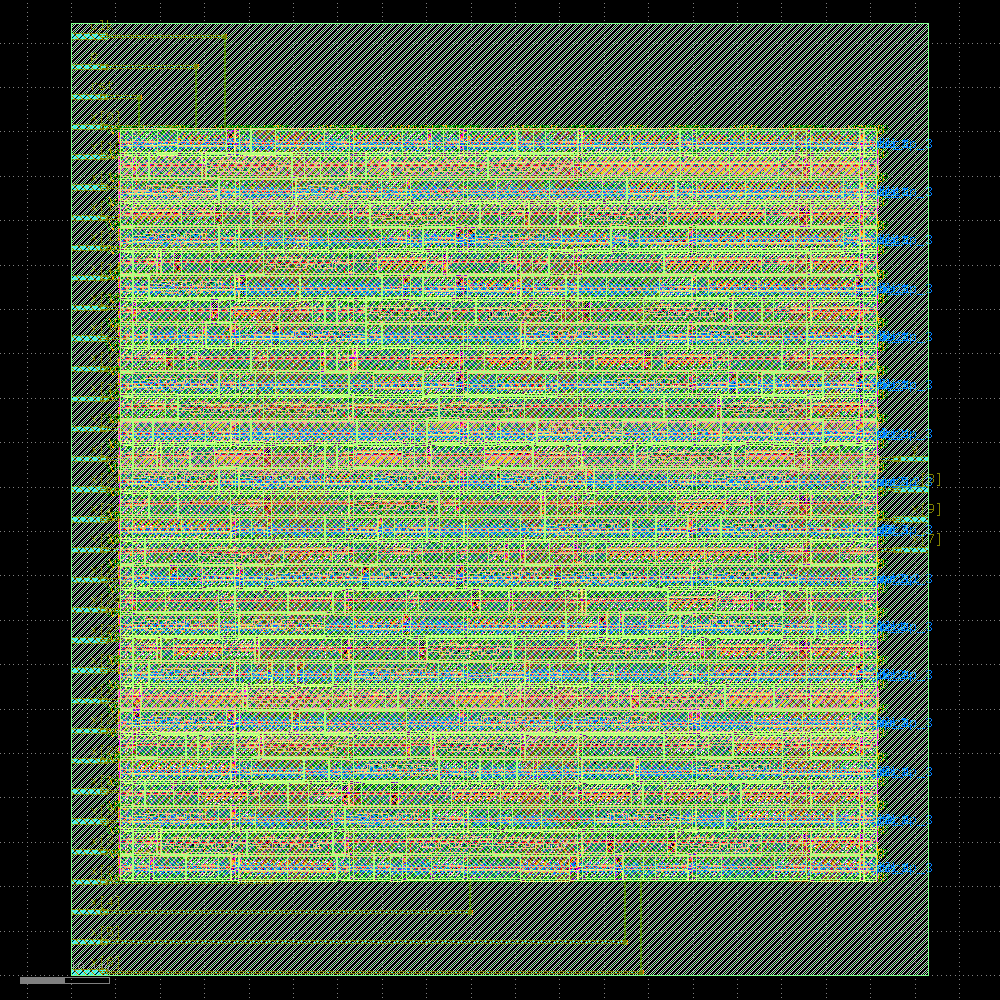

In [68]:
display(gds)

### Design Rule Checks (DRC)

DRC determines that the final layout does not violate any of the rules set by
the foundry to ensure the design is actually manufacturable- for example,
not enough space between two wires, *too much* space between tap cells, and so
on.

A design not passing DRC will typically be rejected by the foundry, who
also run DRC on their side.

In [69]:
DRC = Step.factory.get("Magic.DRC")

drc = DRC(state_in=gds.state_out)
drc.start()

─────────────────────────────────────────────── Design Rule Checks ────────────────────────────────────────────────

[05:40:29] VERBOSE  Running 'Magic.DRC'…                                                               ]8;id=462783;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=834186;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:40:29] VERBOSE  Logging subprocess to ]8;id=625393;file:///content/openlane_run/32-magic-drc/magic-drc.log\openlane_run/]8;;\]8;id=748587;file:///content/openlane_run/32-magic-drc/magic-drc.log\32]8;;\]8;id=625393;file:///content/openlane_run/32-magic-drc/magic-drc.log\-magic-drc/magic-drc.log]8;;\…                     ]8;id=635742;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=220425;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

Warning: Calma reading is not undoable!  I hope that's OK.

Library written using GDS-II Release 6.0

Library name: LIB

Reading "VIA_M1M2_PR_MR".

Reading "VIA_M2M3_PR".

Reading "VIA_M1M2_PR".

Reading "VIA_L1M1_PR_MR".

Reading "VIA_via2_3_2000_480_1_6_320_320".

Reading "VIA_via3_4_2000_480_1_5_400_400".

Reading "VIA_via4_5_2000_480_1_5_400_400".

Reading "VIA_via5_6_2000_2000_1_1_1600_1600".

Reading "sky130_fd_sc_hd__clkbuf_8".

Reading "sky130_fd_sc_hd__clkbuf_4".

Reading "sky130_fd_sc_hd__clkbuf_16".

Reading "sky130_fd_sc_hd__dfrtp_2".

Reading "sky130_fd_sc_hd__nand3_2".

Reading "sky130_fd_sc_hd__a21o_2".

Reading "sky130_fd_sc_hd__xnor2_2".

Reading "sky130_fd_sc_hd__a31o_2".

Reading "sky130_fd_sc_hd__xor2_2".

Reading "sky130_fd_sc_hd__nand2_2".

Reading "sky130_fd_sc_hd__and2_2".

Reading "sky130_fd_sc_hd__inv_2".

Reading "sky130_fd_sc_hd__tapvpwrvgnd_1".

Reading "sky130_fd_sc_hd__decap_3".

Reading "sky130_fd_sc_hd__decap_4".

Reading "sky130_ef_sc_hd__decap_12".

Reading "sky130_fd_sc_hd__decap_6".

Reading "sky130_fd_sc_hd__fill_1".

Reading "sky130_fd_sc_hd__decap_8".

Reading "sky130_fd_sc_hd__fill_2".

Reading "spm".

[INFO] Loading spm

DRC style is now "drc(full)"

Loading DRC CIF style.

No errors found.

[INFO] COUNT: 0

[INFO] Should be divided by 3 or 4

[INFO] DRC Checking DONE (/content/openlane_run/32-magic-drc/reports/drc_violations.magic.rpt)

[INFO] Saving mag view with DRC errors (/content/openlane_run/32-magic-drc/views/spm.drc.mag)

[INFO] Saved

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.lib')}, 'spice': None, 'mag': None, 'gds': Path('/content/openlane_run/31-klayout-streamout/spm.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/31-klayout-streamout/spm.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__displacement__total': Decimal('110.898'), 'design__instance_

### SPICE Extraction for Layout vs. Schematic Check

This step tries to reconstruct a SPICE netlist from the GDSII file, so it can
later be used for the **Layout vs. Schematic** (LVS) check.

In [70]:
SpiceExtraction = Step.factory.get("Magic.SpiceExtraction")

spx = SpiceExtraction(state_in=drc.state_out)
spx.start()

───────────────────────────────────────────── SPICE Model Extraction ──────────────────────────────────────────────

[05:40:33] VERBOSE  Running 'Magic.SpiceExtraction'…                                                   ]8;id=123280;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=977871;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:40:33] VERBOSE  Logging subprocess to                                                              ]8;id=140934;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=784108;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\
                    ]8;id=747329;file:///content/openlane_run/33-magic-spiceextraction/magic-spiceextraction.log\openlane_run/]8;;\]8;id=759388;file:///content/openlane_run/33-magic-spiceextraction/magic-spiceextraction.log\33]8;;\]8;id=747329;file:///content/openlane_run/33-magic-spiceextraction/magic-spiceextraction.log\-magic-spiceextraction/magic-spiceextraction.log]8;;\…                               

Magic 8.3 revision 483 - Compiled on Sun Jun  2 18:57:41 UTC 2024.

Starting magic under Tcl interpreter

Using the terminal as the console.

Using NULL graphics device.

Processing system .magicrc file

Sourcing design .magicrc for technology sky130A ...

2 Magic internal units = 1 Lambda

Input style sky130(): scaleFactor=2, multiplier=2

The following types are not handled by extraction and will be treated as non-electrical types:

ubm

Scaled tech values by 2 / 1 to match internal grid scaling

Loading sky130A Device Generator Menu ...

Loading "/content/openlane_ipynb/openlane/scripts/magic/wrapper.tcl" from command line.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/techlef/sky130_fd_sc_hd__nom.tlef.

This action cannot be undone.

LEF read, Line 78 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 79 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 112 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 114 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 115 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 121 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 122 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 123 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 156 (Message): Unknown keyword "MINENCLOSEDAREA" in LEF file; ignoring.

LEF read, Line 164 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 165 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 167 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 168 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 169 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 206 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 207 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 209 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 210 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 211 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 248 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 249 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read, Line 251 (Message): Unknown keyword "MAXIMUMDENSITY" in LEF file; ignoring.

LEF read, Line 252 (Message): Unknown keyword "DENSITYCHECKWINDOW" in LEF file; ignoring.

LEF read, Line 253 (Message): Unknown keyword "DENSITYCHECKSTEP" in LEF file; ignoring.

LEF read, Line 290 (Message): Unknown keyword "ANTENNAMODEL" in LEF file; ignoring.

LEF read, Line 291 (Message): Unknown keyword "ANTENNADIFFSIDEAREARATIO" in LEF file; ignoring.

LEF read: Processed 797 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_ef_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 278 lines.

> lef read /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef

Reading LEF data from file /root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/lef/sky130_fd_sc_hd.lef.

This action cannot be undone.

LEF read: Processed 56535 lines.

> def read /content/openlane_run/28-openroad-fillinsertion/spm.def -noblockage -labels

Reading DEF data from file /content/openlane_run/28-openroad-fillinsertion/spm.def.

This action cannot be undone.

Processed 4 vias total.

Processed 893 subcell instances total.

Processed 38 pins total.

Processed 2 special nets total.

Processed 330 nets total.

DEF read: Processed 5193 lines.

Moving label "genblk1\[17\].csa.sc" from metal1 to via1 in cell spm.

Moving label "genblk1\[4\].csa.y" from metal1 to via1 in cell spm.

Moving label "genblk1\[5\].csa.sc" from metal1 to via1 in cell spm.

Moving label "x[3]" from metal2 to via2 in cell spm.

Processing spm

Extracting sky130_fd_sc_hd__decap_8 into sky130_fd_sc_hd__decap_8.ext:

Extracting sky130_fd_sc_hd__decap_4 into sky130_fd_sc_hd__decap_4.ext:

Extracting sky130_fd_sc_hd__fill_1 into sky130_fd_sc_hd__fill_1.ext:

Extracting sky130_fd_sc_hd__decap_6 into sky130_fd_sc_hd__decap_6.ext:

Extracting sky130_fd_sc_hd__decap_3 into sky130_fd_sc_hd__decap_3.ext:

Extracting sky130_fd_sc_hd__nand3_2 into sky130_fd_sc_hd__nand3_2.ext:

Extracting sky130_fd_sc_hd__dfrtp_2 into sky130_fd_sc_hd__dfrtp_2.ext:

Extracting sky130_ef_sc_hd__decap_12 into sky130_ef_sc_hd__decap_12.ext:

Extracting sky130_fd_sc_hd__tapvpwrvgnd_1 into sky130_fd_sc_hd__tapvpwrvgnd_1.ext:

Extracting sky130_fd_sc_hd__inv_2 into sky130_fd_sc_hd__inv_2.ext:

Extracting sky130_fd_sc_hd__nand2_2 into sky130_fd_sc_hd__nand2_2.ext:

Extracting sky130_fd_sc_hd__xnor2_2 into sky130_fd_sc_hd__xnor2_2.ext:

Extracting sky130_fd_sc_hd__and2_2 into sky130_fd_sc_hd__and2_2.ext:

Extracting sky130_fd_sc_hd__fill_2 into sky130_fd_sc_hd__fill_2.ext:

Extracting sky130_fd_sc_hd__xor2_2 into sky130_fd_sc_hd__xor2_2.ext:

Extracting sky130_fd_sc_hd__a31o_2 into sky130_fd_sc_hd__a31o_2.ext:

Extracting sky130_fd_sc_hd__a21o_2 into sky130_fd_sc_hd__a21o_2.ext:

Extracting sky130_fd_sc_hd__clkbuf_16 into sky130_fd_sc_hd__clkbuf_16.ext:

Extracting sky130_fd_sc_hd__clkbuf_4 into sky130_fd_sc_hd__clkbuf_4.ext:

Extracting sky130_fd_sc_hd__clkbuf_8 into sky130_fd_sc_hd__clkbuf_8.ext:

Extracting spm into spm.ext:

exttospice finished.

Using technology "sky130A", version 1.0.466-0-gbdc9412

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/33-magic-spiceextraction/spm.spice'), 'mag': None, 'gds': Path('/content/openlane_run/31-klayout-streamout/spm.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/31-klayout-streamout/spm.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__

### Layout vs. Schematic (LVS)

A comparison between the final Verilog netlist (from PnR) and the final
SPICE netlist (extracted.)

This check effectively compares the physically implemented circuit to the final
Verilog netlist output by OpenROAD.

The idea is, if there are any disconnects, shorts or other mismatches in the
physical implementation that do not exist in the logical view of the design,
they would be caught at this step.

Common issues that result in LVS violations include:
* Lack of fill cells or tap cells in the design
* Two unrelated signals to be shorted, or a wire to be disconnected (most
  commonly seen with misconfigured PDN)

Chips with LVS errors are typically dead on arrival.

In [71]:
from openlane.steps import Step

LVS = Step.factory.get("Netgen.LVS")

lvs = LVS(state_in=spx.state_out)
lvs.start()

─────────────────────────────────────────────────── Netgen LVS ────────────────────────────────────────────────────

[05:40:40] VERBOSE  Running 'Netgen.LVS'…                                                              ]8;id=240601;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=831750;file:///content/openlane_ipynb/openlane/steps/step.py#1088\1088]8;;\

[05:40:40] VERBOSE  Logging subprocess to ]8;id=394461;file:///content/openlane_run/34-netgen-lvs/netgen-lvs.log\openlane_run/]8;;\]8;id=557433;file:///content/openlane_run/34-netgen-lvs/netgen-lvs.log\34]8;;\]8;id=394461;file:///content/openlane_run/34-netgen-lvs/netgen-lvs.log\-netgen-lvs/netgen-lvs.log]8;;\…                   ]8;id=394959;file:///content/openlane_ipynb/openlane/steps/step.py\step.py]8;;\:]8;id=594245;file:///content/openlane_ipynb/openlane/steps/step.py#1268\1268]8;;\

Netgen 1.5.270 compiled on Sun Jun  2 19:00:27 UTC 2024

Warning: netgen command 'format' use fully-qualified name '::netgen::format'

Warning: netgen command 'global' use fully-qualified name '::netgen::global'

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Reading SPICE netlist file                                                                                         
'/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__decap_12.spice'...

Call to undefined subcircuit sky130_fd_pr__pfet_01v8_hvt

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_pr__nfet_01v8

Creating placeholder cell definition.

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_12.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_4.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_ef_sc_hd__fill_8.spice'...

Reading SPICE netlist file '/root/.volare/sky130A/libs.ref/sky130_fd_sc_hd/spice/sky130_fd_sc_hd.spice'...

Call to undefined subcircuit sky130_fd_sc_hd__nand2_2

Creating placeholder cell definition.

Call to undefined subcircuit sky130_fd_sc_hd__nor2_2

Creating placeholder cell definition.

Warning:  A case-insensitive file has been read and so the      verilog file must be treated case-insensitive to   
match.

Note:  Implicit pin X in instance clkload0 of sky130_fd_sc_hd__clkbuf_4 in cell spm

Note:  Implicit pin X in instance clkload1 of sky130_fd_sc_hd__clkbuf_8 in cell spm

Note:  Implicit pin X in instance clkload2 of sky130_fd_sc_hd__clkbuf_4 in cell spm

Note:  Implicit pin X in instance clkload3 of sky130_fd_sc_hd__clkbuf_8 in cell spm

Note:  Implicit pin X in instance clkload4 of sky130_fd_sc_hd__clkbuf_4 in cell spm

Note:  Implicit pin X in instance clkload5 of sky130_fd_sc_hd__clkbuf_4 in cell spm

Treating empty subcircuits as black-box cells

Generating JSON file result

Reading setup file /content/openlane_ipynb/openlane/scripts/netgen/setup.tcl

Model sky130_fd_pr__res_generic_po pin end_a == end_b

No property mult found for device sky130_fd_pr__res_generic_po

Model sky130_fd_pr__nfet_01v8 pin 1 == 3

No property mult found for device sky130_fd_pr__nfet_01v8

No property sa found for device sky130_fd_pr__nfet_01v8

No property sb found for device sky130_fd_pr__nfet_01v8

No property sd found for device sky130_fd_pr__nfet_01v8

No property nf found for device sky130_fd_pr__nfet_01v8

No property nrd found for device sky130_fd_pr__nfet_01v8

No property nrs found for device sky130_fd_pr__nfet_01v8

No property area found for device sky130_fd_pr__nfet_01v8

No property perim found for device sky130_fd_pr__nfet_01v8

No property topography found for device sky130_fd_pr__nfet_01v8

Model sky130_fd_pr__pfet_01v8_hvt pin 1 == 3

No property mult found for device sky130_fd_pr__pfet_01v8_hvt

No property sa found for device sky130_fd_pr__pfet_01v8_hvt

No property sb found for device sky130_fd_pr__pfet_01v8_hvt

No property sd found for device sky130_fd_pr__pfet_01v8_hvt

No property nf found for device sky130_fd_pr__pfet_01v8_hvt

No property nrd found for device sky130_fd_pr__pfet_01v8_hvt

No property nrs found for device sky130_fd_pr__pfet_01v8_hvt

No property area found for device sky130_fd_pr__pfet_01v8_hvt

No property perim found for device sky130_fd_pr__pfet_01v8_hvt

No property topography found for device sky130_fd_pr__pfet_01v8_hvt

No property value found for device sky130_fd_pr__diode_pw2nd_05v5

No property mult found for device sky130_fd_pr__diode_pw2nd_05v5

No property perim found for device sky130_fd_pr__diode_pw2nd_05v5

Comparison output logged to file /content/openlane_run/34-netgen-lvs/reports/lvs.netgen.rpt

Logging to file "/content/openlane_run/34-netgen-lvs/reports/lvs.netgen.rpt" enabled

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_6'

Circuit sky130_fd_sc_hd__decap_6 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_6 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__tapvpwrvgnd_1'

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains 0 device instances.

Circuit contains 0 nets, and 2 disconnected pins.

Circuit sky130_fd_sc_hd__tapvpwrvgnd_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xnor2_2'

Circuit sky130_fd_sc_hd__xnor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xnor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__dfrtp_2'

Circuit sky130_fd_sc_hd__dfrtp_2 contains 30 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  15

Class: sky130_fd_pr__pfet_01v8_hvt instances:  15

Circuit contains 21 nets.

Circuit sky130_fd_sc_hd__dfrtp_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__inv_2'

Circuit sky130_fd_sc_hd__inv_2 contains 4 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   2

Class: sky130_fd_pr__pfet_01v8_hvt instances:   2

Circuit contains 6 nets.

Circuit sky130_fd_sc_hd__inv_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_3'

Circuit sky130_fd_sc_hd__decap_3 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_3 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_4'

Circuit sky130_fd_sc_hd__decap_4 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_ef_sc_hd__decap_12'

Circuit sky130_ef_sc_hd__decap_12 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_ef_sc_hd__decap_12 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand2_2'

Circuit sky130_fd_sc_hd__nand2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 8 nets.

Circuit sky130_fd_sc_hd__nand2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__xor2_2'

Circuit sky130_fd_sc_hd__xor2_2 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__xor2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 0 device instances.

Circuit contains 0 nets, and 7 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__and2_2'

Circuit sky130_fd_sc_hd__and2_2 contains 8 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   4

Class: sky130_fd_pr__pfet_01v8_hvt instances:   4

Circuit contains 9 nets.

Circuit sky130_fd_sc_hd__and2_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_2'

Circuit sky130_fd_sc_hd__fill_2 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_16'

Circuit sky130_fd_sc_hd__clkbuf_16 contains 40 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  20

Class: sky130_fd_pr__pfet_01v8_hvt instances:  20

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_16 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 0 device instances.

Circuit contains 0 nets, and 9 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a31o_2'

Circuit sky130_fd_sc_hd__a31o_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 13 nets.

Circuit sky130_fd_sc_hd__a31o_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__decap_8'

Circuit sky130_fd_sc_hd__decap_8 contains 2 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   1

Class: sky130_fd_pr__pfet_01v8_hvt instances:   1

Circuit contains 4 nets.

Circuit sky130_fd_sc_hd__decap_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__fill_1'

Circuit sky130_fd_sc_hd__fill_1 contains 0 device instances.

Circuit contains 0 nets, and 4 disconnected pins.

Circuit sky130_fd_sc_hd__fill_1 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_4'

Circuit sky130_fd_sc_hd__clkbuf_4 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_4 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 0 device instances.

Circuit contains 0 nets, and 6 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__clkbuf_8'

Circuit sky130_fd_sc_hd__clkbuf_8 contains 20 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:  10

Class: sky130_fd_pr__pfet_01v8_hvt instances:  10

Circuit contains 7 nets.

Circuit sky130_fd_sc_hd__clkbuf_8 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__nand3_2'

Circuit sky130_fd_sc_hd__nand3_2 contains 12 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   6

Class: sky130_fd_pr__pfet_01v8_hvt instances:   6

Circuit contains 10 nets.

Circuit sky130_fd_sc_hd__nand3_2 contains no devices.

Contents of circuit 1:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 0 device instances.

Circuit contains 0 nets, and 8 disconnected pins.

Contents of circuit 2:  Circuit: 'sky130_fd_sc_hd__a21o_2'

Circuit sky130_fd_sc_hd__a21o_2 contains 10 device instances.

Class: sky130_fd_pr__nfet_01v8 instances:   5

Class: sky130_fd_pr__pfet_01v8_hvt instances:   5

Circuit contains 11 nets.

Circuit sky130_fd_sc_hd__a21o_2 contains no devices.

Contents of circuit 1:  Circuit: 'spm'

Circuit spm contains 893 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:  31

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__xor2_2 instances:  31

Class: sky130_ef_sc_hd__decap_12 instances:  95

Class: sky130_fd_sc_hd__dfrtp_2 instances:  64

Class: sky130_fd_sc_hd__inv_2 instances:  64

Class: sky130_fd_sc_hd__clkbuf_4 instances:   4

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances: 115

Class: sky130_fd_sc_hd__decap_4 instances:  51

Class: sky130_fd_sc_hd__decap_6 instances:  34

Class: sky130_fd_sc_hd__decap_8 instances:  50

Class: sky130_fd_sc_hd__nand2_2 instances:  31

Class: sky130_fd_sc_hd__and2_2 instances:  32

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:  99

Class: sky130_fd_sc_hd__fill_1 instances: 100

Class: sky130_fd_sc_hd__fill_2 instances:  48

Circuit contains 338 nets.

Contents of circuit 2:  Circuit: 'spm'

Circuit spm contains 893 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:  31

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__xor2_2 instances:  31

Class: sky130_ef_sc_hd__decap_12 instances:  95

Class: sky130_fd_sc_hd__dfrtp_2 instances:  64

Class: sky130_fd_sc_hd__inv_2 instances:  64

Class: sky130_fd_sc_hd__clkbuf_4 instances:   4

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances: 115

Class: sky130_fd_sc_hd__decap_4 instances:  51

Class: sky130_fd_sc_hd__decap_6 instances:  34

Class: sky130_fd_sc_hd__decap_8 instances:  50

Class: sky130_fd_sc_hd__nand2_2 instances:  31

Class: sky130_fd_sc_hd__and2_2 instances:  32

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:  99

Class: sky130_fd_sc_hd__fill_1 instances: 100

Class: sky130_fd_sc_hd__fill_2 instances:  48

Circuit contains 338 nets.

Circuit was modified by parallel/series device merging.

New circuit summary:

Contents of circuit 1:  Circuit: 'spm'

Circuit spm contains 309 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:  31

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__xor2_2 instances:  31

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances:  64

Class: sky130_fd_sc_hd__inv_2 instances:  64

Class: sky130_fd_sc_hd__clkbuf_4 instances:   4

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__nand2_2 instances:  31

Class: sky130_fd_sc_hd__and2_2 instances:  32

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Circuit contains 338 nets.

Contents of circuit 2:  Circuit: 'spm'

Circuit spm contains 309 device instances.

Class: sky130_fd_sc_hd__a31o_2 instances:  31

Class: sky130_fd_sc_hd__a21o_2 instances:   1

Class: sky130_fd_sc_hd__clkbuf_16 instances:   9

Class: sky130_fd_sc_hd__xor2_2 instances:  31

Class: sky130_ef_sc_hd__decap_12 instances:   1

Class: sky130_fd_sc_hd__dfrtp_2 instances:  64

Class: sky130_fd_sc_hd__inv_2 instances:  64

Class: sky130_fd_sc_hd__clkbuf_4 instances:   4

Class: sky130_fd_sc_hd__clkbuf_8 instances:   2

Class: sky130_fd_sc_hd__nand3_2 instances:   1

Class: sky130_fd_sc_hd__decap_3 instances:   1

Class: sky130_fd_sc_hd__decap_4 instances:   1

Class: sky130_fd_sc_hd__decap_6 instances:   1

Class: sky130_fd_sc_hd__decap_8 instances:   1

Class: sky130_fd_sc_hd__nand2_2 instances:  31

Class: sky130_fd_sc_hd__and2_2 instances:  32

Class: sky130_fd_sc_hd__xnor2_2 instances:  31

Class: sky130_fd_sc_hd__tapvpwrvgnd_1 instances:   1

Class: sky130_fd_sc_hd__fill_1 instances:   1

Class: sky130_fd_sc_hd__fill_2 instances:   1

Circuit contains 338 nets.

Circuit 1 contains 309 devices, Circuit 2 contains 309 devices.

Circuit 1 contains 338 nets,    Circuit 2 contains 338 nets.

Final result:

Circuits match uniquely.

.

Logging to file "/content/openlane_run/34-netgen-lvs/reports/lvs.netgen.rpt" disabled

LVS Done.

{'nl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.nl.v'), 'pnl': Path('/content/openlane_run/28-openroad-fillinsertion/spm.pnl.v'), 'pnl-sdf-friendly': None, 'pnl-npc': None, 'def': Path('/content/openlane_run/28-openroad-fillinsertion/spm.def'), 'lef': None, 'openroad-lef': None, 'odb': Path('/content/openlane_run/28-openroad-fillinsertion/spm.odb'), 'sdc': Path('/content/openlane_run/28-openroad-fillinsertion/spm.sdc'), 'sdf': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.sdf'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.sdf'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.sdf'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.sdf'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.sdf'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.sdf'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.sdf'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.sdf'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.sdf')}, 'spef': {'nom_*': Path('/content/openlane_run/29-openroad-rcx/nom/spm.nom.spef'), 'min_*': Path('/content/openlane_run/29-openroad-rcx/min/spm.min.spef'), 'max_*': Path('/content/openlane_run/29-openroad-rcx/max/spm.max.spef')}, 'lib': {'nom_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/nom_tt_025C_1v80/spm__nom_tt_025C_1v80.lib'), 'nom_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ss_100C_1v60/spm__nom_ss_100C_1v60.lib'), 'nom_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/nom_ff_n40C_1v95/spm__nom_ff_n40C_1v95.lib'), 'min_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/min_tt_025C_1v80/spm__min_tt_025C_1v80.lib'), 'min_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/min_ss_100C_1v60/spm__min_ss_100C_1v60.lib'), 'min_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/min_ff_n40C_1v95/spm__min_ff_n40C_1v95.lib'), 'max_tt_025C_1v80': Path('/content/openlane_run/30-openroad-stapostpnr/max_tt_025C_1v80/spm__max_tt_025C_1v80.lib'), 'max_ss_100C_1v60': Path('/content/openlane_run/30-openroad-stapostpnr/max_ss_100C_1v60/spm__max_ss_100C_1v60.lib'), 'max_ff_n40C_1v95': Path('/content/openlane_run/30-openroad-stapostpnr/max_ff_n40C_1v95/spm__max_ff_n40C_1v95.lib')}, 'spice': Path('/content/openlane_run/33-magic-spiceextraction/spm.spice'), 'mag': None, 'gds': Path('/content/openlane_run/31-klayout-streamout/spm.gds'), 'mag_gds': None, 'klayout_gds': Path('/content/openlane_run/31-klayout-streamout/spm.klayout.gds'), 'json_h': None, 'vh': None, 'metrics': {'design__instance__count': 400, 'design__instance__area': Decimal('4061.4'), 'design__instance_unmapped__count': 0, 'synthesis__check_error__count': 0, 'design__die__bbox': '0.0 0.0 96.535 107.255', 'design__core__bbox': '5.52 10.88 90.62 95.2', 'flow__warnings__count': 1, 'flow__errors__count': 0, 'design__io': 38, 'design__die__area': Decimal('10353.9'), 'design__core__area': Decimal('7175.63'), 'design__instance__count__stdcell': 400, 'design__instance__area__stdcell': Decimal('4061.4'), 'design__instance__count__macros': 0, 'design__instance__area__macros': 0, 'design__instance__utilization': Decimal('0.565998'), 'design__instance__utilization__stdcell': Decimal('0.565998'), 'floorplan__design__io': 36, 'design__io__hpwl': 2621616, 'design__power_grid_violation__count__net:VPWR': 0, 'design__power_grid_violation__count__net:VGND': 0, 'design__power_grid_violation__count': 0, 'design__instance__